<h2>Start Here</h2>
Import the required modules below

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import datetime
import random
import os

<h2>Initialize Raw Data</h2>
The following block will import the text datafiles and process them into Pandas dataframes

In [47]:
file_dir = os.path.abspath('')

data = {}

for datafile in ['agency', 'calendar_dates', 'calendar', 'direction_names_exceptions', 'directions', \
    'routes', 'shapes', 'stop_order_exceptions', 'stops', 'trips']:
    data[datafile] = pd.read_table(file_dir + u'\\' + datafile + '.txt', sep = ',')

stop_times_dataframe = []
for page in range(1,37):
    stop_times_dataframe.append(pd.read_table(file_dir + u'\\' + 'stop_times_' + str(page) + '.txt', sep = ','))
data['stop_times'] = pd.concat(stop_times_dataframe, ignore_index=True)

C:\Users\rayng\AppData\Local\Temp\ipykernel_16648\4225842230.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data[datafile] = pd.read_table(file_dir + u'\\' + datafile + '.txt', sep = ',')


<h2>Configure Data</h2>
This block will configure required classes and data:

* Agency
* Stops
* Routes
* Route Directions
* Trips
* Stop Times
* Shapes and Points
* Services

For details about the GTFS file, see https://gtfs.org/schedule/reference/#tripstxt

In [48]:
# Configure Agency class and data

class Agency:
    def __init__(self, name, url, timezone, lang):
        self.name = name
        self.url = url
        self.timezone = timezone
        self.lang = lang

agency = {}

agency_data = data['agency']

for index in range(agency_data.size // agency_data.columns.size):
    agency_id = agency_data.agency_id[index]
    name = agency_data.agency_name[index]
    url = agency_data.agency_url[index]
    timezone = agency_data.agency_timezone[index]
    lang = agency_data.agency_lang[index]

    agency[agency_id] = Agency(name, url, timezone, lang)

# Configure Stop class and data

class Stop:
    def __init__(self, code, name, desc, lat, lon, zone, url, location_type, parent_station):
        self.code = code
        self.name = name
        self.desc = desc
        self.lat = lat
        self.lon = lon
        self.zone = zone
        self.url = url
        self.location_type = location_type
        self.parent_station = parent_station
        self.routes_served = []
        self.trip_times = {}

stops = {}

stop_lookup = {}

stop_data = data['stops']

for index in range(stop_data.size // stop_data.columns.size):
    stop_id = stop_data.stop_id[index]
    code = stop_data.stop_code[index]
    try:
        code = int(code)
    except:
        pass
    name = stop_data.stop_name[index]
    desc = stop_data.stop_desc[index]
    lat = stop_data.stop_lat[index]
    lon = stop_data.stop_lon[index]
    zone = stop_data.zone_id[index]
    url = stop_data.stop_url[index]
    location_type = stop_data.location_type[index]
    parent_station = stop_data.parent_station[index]

    stops[stop_id] = Stop(code, name, desc, lat, lon, zone, url, location_type, parent_station)
    if not pd.isna(code):
        stop_lookup[code] = stop_id

# Configure Route class and data

class Route:
    def __init__(self, agency, short_name, long_name, desc, route_type, url, color, text_color):
        self.agency = agency
        self.short_name = short_name
        self.long_name = long_name
        self.desc = desc
        self.type = route_type
        self.url = url
        self.color = color
        self.text_color = text_color
        self.directions = {}
        self.trips = []

routes = {}

route_lookup = {}

route_data = data['routes']

for index in range(route_data.size // route_data.columns.size):
    try:
        route_id = int(route_data.route_id[index])
    except:
        route_id = route_data.route_id[index]
    agency = route_data.agency_id[index]
    short_name = route_data.route_short_name[index]
    long_name = route_data.route_long_name[index]
    desc = route_data.route_desc[index]
    route_type = route_data.route_type[index]
    url = route_data.route_url[index]
    color = route_data.route_color[index]
    text_color = route_data.route_text_color[index]

    routes[route_id] = Route(agency, short_name, long_name, desc, route_type, url, color, text_color)
    try:
        route_lookup[int(short_name)] = route_id
    except:
        route_lookup[short_name] = route_id

# Configure Direction data for routes

direction_data = data['directions']

for index in range(direction_data.size // direction_data.columns.size):
    direction_name = direction_data.direction[index]
    direction_id = direction_data.direction_id[index]
    route_id = direction_data.route_id[index]

    if route_id in routes:
        routes[route_id].directions[direction_id] = direction_name

# Configure Trip class and data

class Trip:
    def __init__(self, route, service, headsign, short_name, direction, block, shape, wheelchair, bikes):
        self.route = route
        try:
            self.service = int(service)
        except:
            self.service = service
        self.headsign = headsign
        self.short_name = short_name
        self.direction = direction
        self.block = block
        self.shape = shape
        self.wheelchair = wheelchair
        self.bikes = bikes
        self.stop_times_dict = {}
        self.stop_times = []

trips = {}

trip_data = data['trips']

for index in range(trip_data.size // trip_data.columns.size):
    try:
        route = int(trip_data.route_id[index])
    except:
        route = trip_data.route_id[index]
    service = trip_data.service_id[index]
    trip_id = trip_data.trip_id[index]
    headsign = trip_data.trip_headsign[index]
    short_name = trip_data.trip_short_name[index]
    direction = trip_data.direction_id[index]
    block = trip_data.block_id[index]
    shape = trip_data.shape_id[index]
    wheelchair = trip_data.wheelchair_accessible[index]
    bikes = trip_data.bikes_allowed[index]

    trips[trip_id] = Trip(route, service, headsign, short_name, direction, block, shape, wheelchair, bikes)

    if trip_id not in routes[route].trips:
        routes[route].trips.append(trip_id)

# Configure Stop_Time class and data and add stop times to each trip

class StopTime:
    def __init__(self, sequence, arrival, departure, stop_id, headsign, pickup, dropoff, dist):
        self.sequence = sequence
        self.arrival = arrival
        self.departure = departure
        self.stop_id = stop_id
        self.headsign = headsign
        self.pickup = pickup
        self.dropoff = dropoff
        self.dist = dist

stoptime_data = data['stop_times'].sort_values(['trip_id', 'stop_sequence'], ignore_index = True)

for index in range(stoptime_data.size // stoptime_data.columns.size):
    trip_id = stoptime_data.trip_id[index]
    arrival = stoptime_data.arrival_time[index]
    departure = stoptime_data.departure_time[index]
    stop_id = stoptime_data.stop_id[index]
    sequence = stoptime_data.stop_sequence[index]
    headsign = stoptime_data.stop_headsign[index]
    pickup = stoptime_data.pickup_type[index]
    dropoff = stoptime_data.drop_off_type[index]
    dist = stoptime_data.shape_dist_traveled[index]

    stop_time = StopTime(sequence, arrival, departure, stop_id, headsign, pickup, dropoff, dist)

    trips[trip_id].stop_times_dict[sequence] = stop_time

    if (trips[trip_id].route, trips[trip_id].direction) not in stops[stop_id].routes_served:
        stops[stop_id].routes_served.append((trips[trip_id].route, trips[trip_id].direction))

    stops[stop_id].trip_times[trip_id] = departure

# Convert stop_times dictionary into ordered array

for trip in trips:
    sequence = 0
    while len(trips[trip].stop_times) < len(trips[trip].stop_times_dict):
        if sequence in trips[trip].stop_times_dict:
            trips[trip].stop_times.append(trips[trip].stop_times_dict[sequence])
        sequence += 1

# Configure Shape and Point class and data

class Shape:
    def __init__(self):
        self.points = {}

class Point:
    def __init__(self, lat, lon, dist):
        self.lat = lat
        self.lon = lon
        self.dist = dist

shapes = {}

shape_data = data['shapes'].sort_values(['shape_id', 'shape_pt_sequence'], ignore_index = True)

for index in range(shape_data.size // shape_data.columns.size):
    shape_id = shape_data.shape_id[index]
    lat = shape_data.shape_pt_lat[index]
    lon = shape_data.shape_pt_lon[index]
    seq = shape_data.shape_pt_sequence[index]
    dist = shape_data.shape_dist_traveled[index]

    point = Point(lat, lon, dist)

    if shape_id not in shapes:
        shapes[shape_id] = Shape()
    shapes[shape_id].points[seq] = point

# Configure Service class and data

class Service:
    def __init__(self, mon, tue, wed, thu, fri, sat, sun, start, end):
        self.mon = mon
        self.tue = tue
        self.wed = wed
        self.thu = thu
        self.fri = fri
        self.sat = sat
        self.sun = sun
        self.start_date = start
        self.end_date = end
        self.added_dates = []
        self.removed_dates = []

services = {}

calendar_data = data['calendar']

for index in range(calendar_data.size // calendar_data.columns.size):
    try:
        service_id = int(calendar_data.service_id[index])
    except:
        service_id = calendar_data.service_id[index]

    mon = calendar_data.monday[index]
    tue = calendar_data.tuesday[index]
    wed = calendar_data.wednesday[index]
    thu = calendar_data.thursday[index]
    fri = calendar_data.friday[index]
    sat = calendar_data.saturday[index]
    sun = calendar_data.sunday[index]
    start = calendar_data.start_date[index]
    end = calendar_data.end_date[index]
    
    services[service_id] = Service(mon, tue, wed, thu, fri, sat, sun, start, end)

calendar_exceptions = data['calendar_dates']

for index in range(calendar_exceptions.size // calendar_exceptions.columns.size):
    try:
        service_id = int(calendar_exceptions.service_id[index])
    except:
        service_id = calendar_exceptions.service_id[index]
    date = calendar_exceptions.date[index]
    exception = calendar_exceptions.exception_type[index]

    if exception == 1:
        services[service_id].added_dates.append(date)
    elif exception == 2:
        services[service_id].removed_dates.append(date)

<h2>Functions</h2>
Next, we will write some functions. The following function will print out the stops and times of a random trip and plot a Matplotlib graph for the route served by the trip

In [49]:
# Example function: Plot a random trip and its stops

def plot_trip(trip_id, add_labels=False):
    plt.rcParams.update(plt.rcParamsDefault)

    trip = trips[trip_id]

    fig, ax = plt.subplots()

    points = shapes[trip.shape].points
    lats = [points[point].lat for point in points]
    lons = [points[point].lon for point in points]
    trip_stops = trip.stop_times
    stop_lats = [stops[stop.stop_id].lat for stop in trip_stops]
    stop_lons = [stops[stop.stop_id].lon for stop in trip_stops]

    # Plot route
    fig.suptitle(trip.headsign + ' starting at ' + trip.stop_times[0].departure)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    if pd.isna(routes[trip.route].color):
        color = '#000000'
    else:
        color = '#' + str(routes[trip.route].color)
    ax.plot(lons, lats, color=color)
    ax.plot(stop_lons, stop_lats, 'o', markersize=4, color=color)
    
    if add_labels == True:
        for stop in trip_stops:
            ax.annotate(stops[stop.stop_id].code, (stops[stop.stop_id].lon, stops[stop.stop_id].lat))

    if stop_lats != []:
        lat_max = max(stop_lats)
    if stop_lats != []:
        lat_min = min(stop_lats)
        
    ax.set_aspect(1/np.cos(np.radians((lat_min+lat_max)/2)))
    ax.set_box_aspect(1)

    plt.show()

    # Print stops
    for stop in trip_stops:
        print(str(stop.sequence) + '. ' + str(stops[stop.stop_id].code) + ' ' + stops[stop.stop_id].name + ' ' + stop.departure)

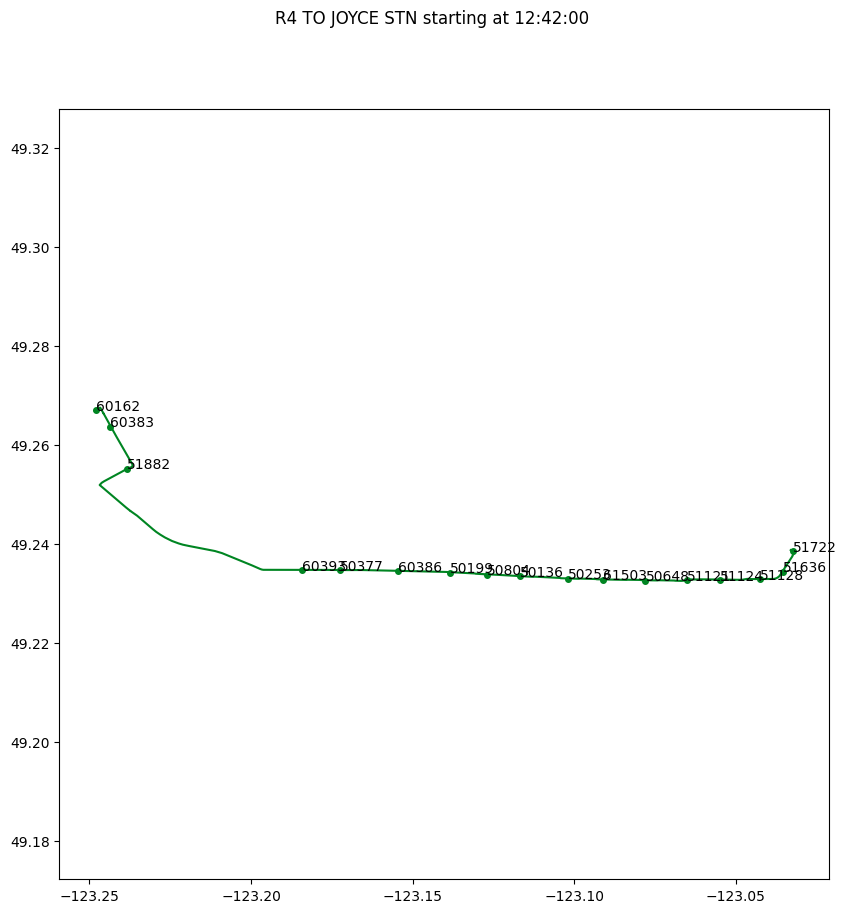

1. 60162 UBC Exchange @ Bay 4 12:42:00
2. 60383 Southbound Wesbrook Mall @ Agronomy Rd 12:43:24
3. 51882 Westbound W 16 Ave @ Wesbrook Mall 12:46:10
4. 60393 Dunbar Loop @ Bay 7 13:00:11
5. 50377 Eastbound W 41 Ave @ Carnarvon St 13:02:15
6. 60386 Eastbound W 41 Ave @ East Blvd 13:05:26
7. 50199 Eastbound W 41 Ave @ Granville St 13:08:14
8. 50804 Eastbound W 41 Ave @ Oak St 13:10:17
9. 50136 Oakridge-41st Ave Station @ Bay 2 13:11:56
10. 50253 Eastbound E 41 Ave @ Main St 13:14:42
11. 61503 Eastbound E 41 Ave @ Fraser St 13:16:37
12. 50648 Eastbound E 41 Ave @ Knight St 13:18:55
13. 51121 Eastbound E 41 Ave @ Victoria Dr 13:21:12
14. 51124 Eastbound E 41 Ave @ Clarendon St 13:23:00
15. 51128 Eastbound E 41 Ave @ Rupert St 13:25:10
16. 51636 Northbound Joyce St @ Kingsway 13:26:34
17. 51722 Joyce Station @ Unloading Only 13:28:00


In [50]:
trip_id = random.choice(list(trips.keys()))
plot_trip(trip_id, add_labels = True)

This function plots all trips given a route number

In [51]:
# Example function: Plot a chosen route and its trips and stops

def plot_route(route_id, direction_plot=None, add_labels=False):
    route = routes[route_id]

    plt.rcParams.update(plt.rcParamsDefault)
    if str(route.short_name)[0] == 'N':
        plt.style.use('dark_background')

    fig, ax = plt.subplots()
    fig.suptitle(str(route.short_name) + ' ' + str(route.long_name))
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.set_aspect('equal')
    ax.set_box_aspect(1)

    plotted_shapes = []
    plotted_shapes_limited = []
    plotted_stops = []

    lat_min = float('inf')
    lat_max = float('-inf')

    for trip_id in route.trips:
        trip = trips[trip_id]
        direction = trip.direction
        points = shapes[trip.shape].points
        lats = [points[point].lat for point in points]
        lons = [points[point].lon for point in points]
        trip_stops = trip.stop_times
        trip_stops_filtered = list(filter((lambda stop: stop.stop_id not in plotted_stops), trip_stops))
        plotted_stops += [stop.stop_id for stop in trip_stops_filtered]
        stop_lats = [stops[stop.stop_id].lat for stop in trip_stops_filtered]
        stop_lons = [stops[stop.stop_id].lon for stop in trip_stops_filtered]
        stop_codes = [stops[stop.stop_id].code for stop in trip_stops_filtered]

        if stop_lats != [] and max(stop_lats) > lat_max:
            lat_max = max(stop_lats)
        if stop_lats != [] and min(stop_lats) < lat_min:
            lat_min = min(stop_lats)

        # Plot route
        if direction == 0:
            color = '#ff0000'
        elif direction == 1:
            color = '#0000ff'
        
        if (direction_plot == 0 and direction == 0) or (direction_plot == 1 and direction == 1) or direction_plot == None:
            if trip.service in [1,2,3]:
                if trip.shape not in plotted_shapes:
                    ax.plot(lons, lats, '-', linewidth=2, color=color)
                    plotted_shapes.append(trip.shape)
            else:
                if trip.shape not in plotted_shapes_limited:
                    ax.plot(lons, lats, ':', linewidth=2, color=color)
                    plotted_shapes_limited.append(trip.shape)
                
            ax.plot(stop_lons, stop_lats, 'o', markersize=4, color=color)

            if add_labels == True:
                for stop in range(len(trip_stops_filtered)):
                    ax.annotate(stop_codes[stop], (stop_lons[stop], stop_lats[stop]))
    
    ax.set_aspect(1/np.cos(np.radians((lat_min+lat_max)/2)))

    plt.show()

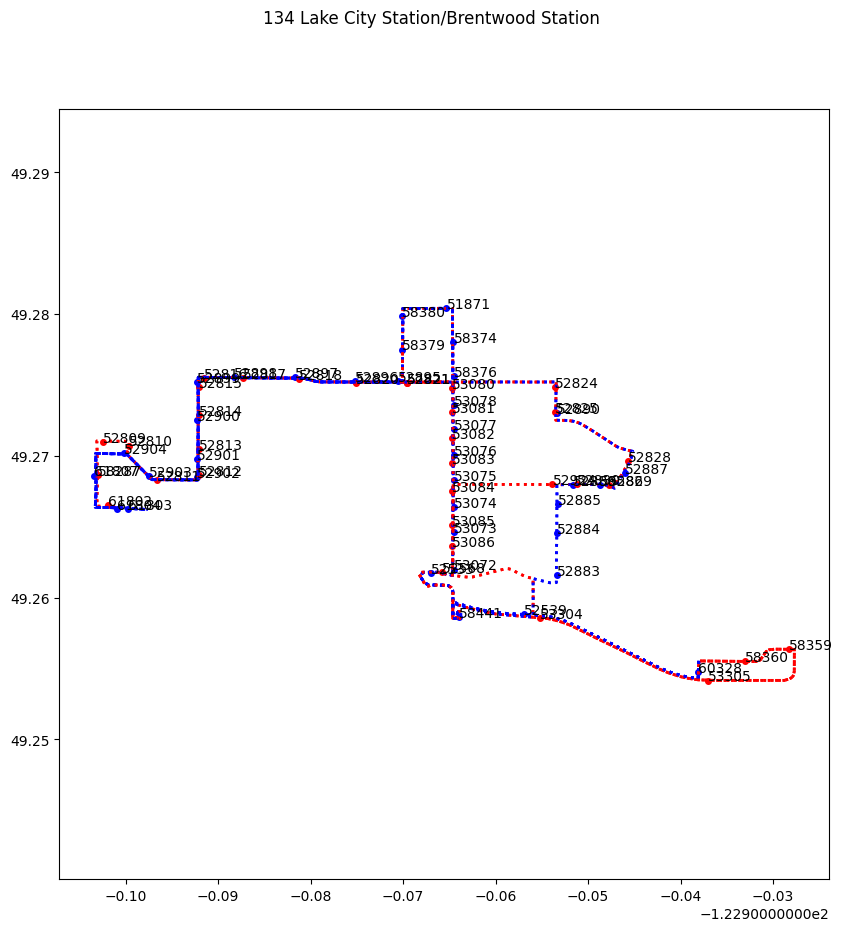

In [52]:
plot_route(route_lookup[134], add_labels=True)

In [53]:
# Example function: Print out stops serving a chosen stop

stop = stops[stop_lookup[53032]]
print(stop.code, stop.name)
for route in stop.routes_served:
    print(routes[route[0]].short_name, routes[route[0]].long_name, routes[route[0]].directions[route[1]])

53032 Northbound Shaughnessy St @ Lions Way
159 Coquitlam Central Station/Braid Station EAST
160 Port Coquitlam Station/Kootenay Loop WEST
174 Coquitlam Central Station/Rocklin EAST


This is a data cell to provide coordinate boundaries of specific regions

In [54]:
# Specify boundary coordinates for regions

complete = [-123.45,-122.30,49.00,49.50]
dt_vancouver = [-123.15,-123.10,49.27,49.30]
vancouver = [-123.28,-123.01,49.20,49.31]
burnaby = [-123.04,-122.88,49.18,49.30]
coquitlam = [-122.93,-122.71,49.22,49.33]
nw_vancouver = [-123.29,-122.94,49.30,49.38]
bowen_island = [-123.43,-123.31,49.35,49.41]
maple_ridge = [-122.70,-122.42,49.16,49.27]
surrey = [-122.98,-122.75,49.08,49.22]
langley = [-122.76,-122.57,49.03,49.19]
white_rock = [-122.90,-122.75,49.01,49.10]
richmond = [-123.20,-123.06,49.12,49.20]
delta = [-123.14,-122.99,49.00,49.12]

Helper function to convert a date string (yyyymmdd) into a Date data type

In [55]:
def date_string_to_date(date):
    return datetime.date(date // 10000, (date % 10000) // 100, (date % 100))

Helper function to test if a trip is available on a given date or weekday

In [56]:
def service_available(trip_id, date, weekday=None):
    trip = trips[trip_id]
    
    service_available = True

    if date != None:
        weekday = datetime.date(date // 10000, (date % 10000) // 100, (date % 100)).weekday()
        service_available = False

    start_date = date_string_to_date(services[trip.service].start_date)
    end_date = date_string_to_date(services[trip.service].end_date)
    date_in_range = False
    try:
        if start_date <= date_string_to_date(date) <= end_date:
            date_in_range = True
    except:
        pass
    
    if date_in_range:
        if weekday != None:
            if weekday == 0 and services[trip.service].mon == 1:
                service_available = True
            elif weekday == 1 and services[trip.service].tue == 1:
                service_available = True
            elif weekday == 2 and services[trip.service].wed == 1:
                service_available = True
            elif weekday == 3 and services[trip.service].thu == 1:
                service_available = True
            elif weekday == 4 and services[trip.service].fri == 1:
                service_available = True
            elif weekday == 5 and services[trip.service].sat == 1:
                service_available = True
            elif weekday == 6 and services[trip.service].sun == 1:
                service_available = True

        if date != None:
            if date in services[trip.service].added_dates:
                service_available = True
            elif date in services[trip.service].removed_dates:
                service_available = False

        if weekday == None and date == None:
            service_available = True
    
    return service_available

The next cell plots multiple routes in a given region. All routes are plotted with stops plotted with dots. Colors are randomly assigned to each route unless specified by the data, such as Skytrain lines or RapidBus lines.

This function will use the following parameters:

* `bounds` is a necessary parameter - an interable of length 4 in the following order: [west end, east end, south end, north end].
* `plotted_routes` specifies which routes to plot, default all routes.
* `weekday` specifies a day of week (0=Monday, 6=Sunday). If not specified, plots all routes. If specified, plots only routes served on that day of week.
* `date` specifies a date, in int format with date format yyyymmdd. If not specified, plots routes according to whether `weekday` is specified. If specified, to allow for service changes on special days, automatically configures `weekday` according to the date and plots routes served on that date.
* `legend` is a Boolean specifying whether to include a legend. Legend will show all routes plotted within the boundaries.
* `stop_labels` is a Boolean specifying whether to put stop codes on all plotted stops.
* `shake` is a float parameter specifying the standard deviation of moving plotted routes and stops, to move each route randomly according to a normal (Gaussian) distribution. Used to distinguish overlapping routes.

In [57]:
# Function construction: Plot routes in a route map

def plot_routes(bounds, plotted_routes=routes, night=False, weekday=None, date=None, legend=True, stop_labels=False, \
    gridlines=False, plot_size=20, shake=0):
    x1,x2,y1,y2 = bounds

    # Step 1: Configure Matplotlib plot settings
    if date != None:
        weekday = datetime.date(date // 10000, (date % 10000) // 100, (date % 100)).weekday()

    if night == False:
        plt.rcParams.update(plt.rcParamsDefault)
    elif night == True:
        plt.rcParams.update(plt.rcParamsDefault)
        plt.style.use('dark_background')
    
    fig, ax = plt.subplots()
    fig.set_figheight(plot_size)
    fig.set_figwidth(plot_size)
    ax.set_xlim([x1,x2])
    ax.set_ylim([y1,y2])
    ax.set_aspect(1/np.cos(np.radians((y1+y2)/2)))

    # Step 2: Draw coordinate gridlines on plot
    if gridlines == True:
        if night == False:
            gridline_color = '#e0e0e0'
        elif night == True:
            gridline_color = '#202020'

        for y_line in range(int(x1//0.01), int(x2//0.01)+2):
            if y_line % 10 == 0:
                width = 3
            else:
                width = 1
            ax.plot([y_line/100,y_line/100],[y1,y2],color=gridline_color,linewidth=width)
            
        for x_line in range(int(y1//0.01), int(y2//0.01)+2):
            if x_line % 10 == 0:
                width = 3
            else:
                width = 1
            ax.plot([x1,x2],[x_line/100,x_line/100],color=gridline_color,linewidth=width)

    # Step 3: Plot the routes on the map
    legend_labels = []
    plotted_stops = []

    for route_id in plotted_routes:
        shift_x = np.random.normal(scale=shake)
        shift_y = np.random.normal(scale=shake) * np.cos(np.radians((y1+y2)/2))
        route = routes[route_id]
        if night == False and str(route.short_name)[0] == 'N':
            continue
        if night == True and str(route.short_name)[0] != 'N':
            continue

        if pd.isna(route.color):
            rand_color = random.randint(0,16777215)
            route_color = '#' + f'{rand_color:0>6X}'
        else:
            route_color = '#' + str(route.color)

        route_shapes = []
        route_stops = []

        # Plot route only if service is available
        for trip_id in route.trips:
            available = service_available(trip_id, date, weekday)

            trip = trips[trip_id]
                            
            if available:
                if trip.shape not in route_shapes and not pd.isna(trip.shape):
                    route_shapes.append(trip.shape)
                for stop in trip.stop_times:
                    if stop.stop_id not in route_stops:
                        route_stops.append(stop.stop_id)

        if route.type == 1:
            width = 4
            stop_size = 12
        elif route.type == 2:
            width = 4
            stop_size = 12
        elif route.type == 3:
            width = 1
            stop_size = 4
        elif route.type == 4:
            width = 1
            stop_size = 4

        if not pd.isna(route.color):
            if width < 3:
                width = 3
            if stop_size < 8:
                stop_size = 8

        width = len(route.trips)/200

        in_boundary = False

        for shape in route_shapes:
            points = shapes[shape].points
            lats = [points[point].lat + shift_x for point in points]
            lons = [points[point].lon + shift_y for point in points]
            ax.plot(lons, lats, color=route_color, linewidth=width)

            for point in points:
                if x1 <= points[point].lon <= x2 and y1 <= points[point].lat <= y2:
                    in_boundary = True

        stop_lats = [stops[stop].lat + shift_x for stop in route_stops]
        stop_lons = [stops[stop].lon + shift_y for stop in route_stops]
        ax.plot(stop_lons, stop_lats, 'o', markersize=stop_size, color=route_color)

        for stop in route_stops:
            if x1 <= stops[stop].lon <= x2 and y1 <= stops[stop].lat <= y2:
                in_boundary = True
                if stop not in plotted_stops:
                    plotted_stops.append(stop)

        if in_boundary:
            if pd.isna(route.short_name):
                legend_labels.append(mpatches.Patch(color=route_color, label=route.long_name))
            else:
                legend_labels.append(mpatches.Patch(color=route_color, label=route.short_name))

    if legend == True:
        ax.legend(handles=legend_labels, ncol = len(legend_labels) // 50 + 1)

    if stop_labels == True:
        for stop in plotted_stops:
            plt.text(stops[stop].lon,stops[stop].lat,stops[stop].code, horizontalalignment='center')
    
    plt.show()

Plot all routes within various regions

c:\Users\rayng\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


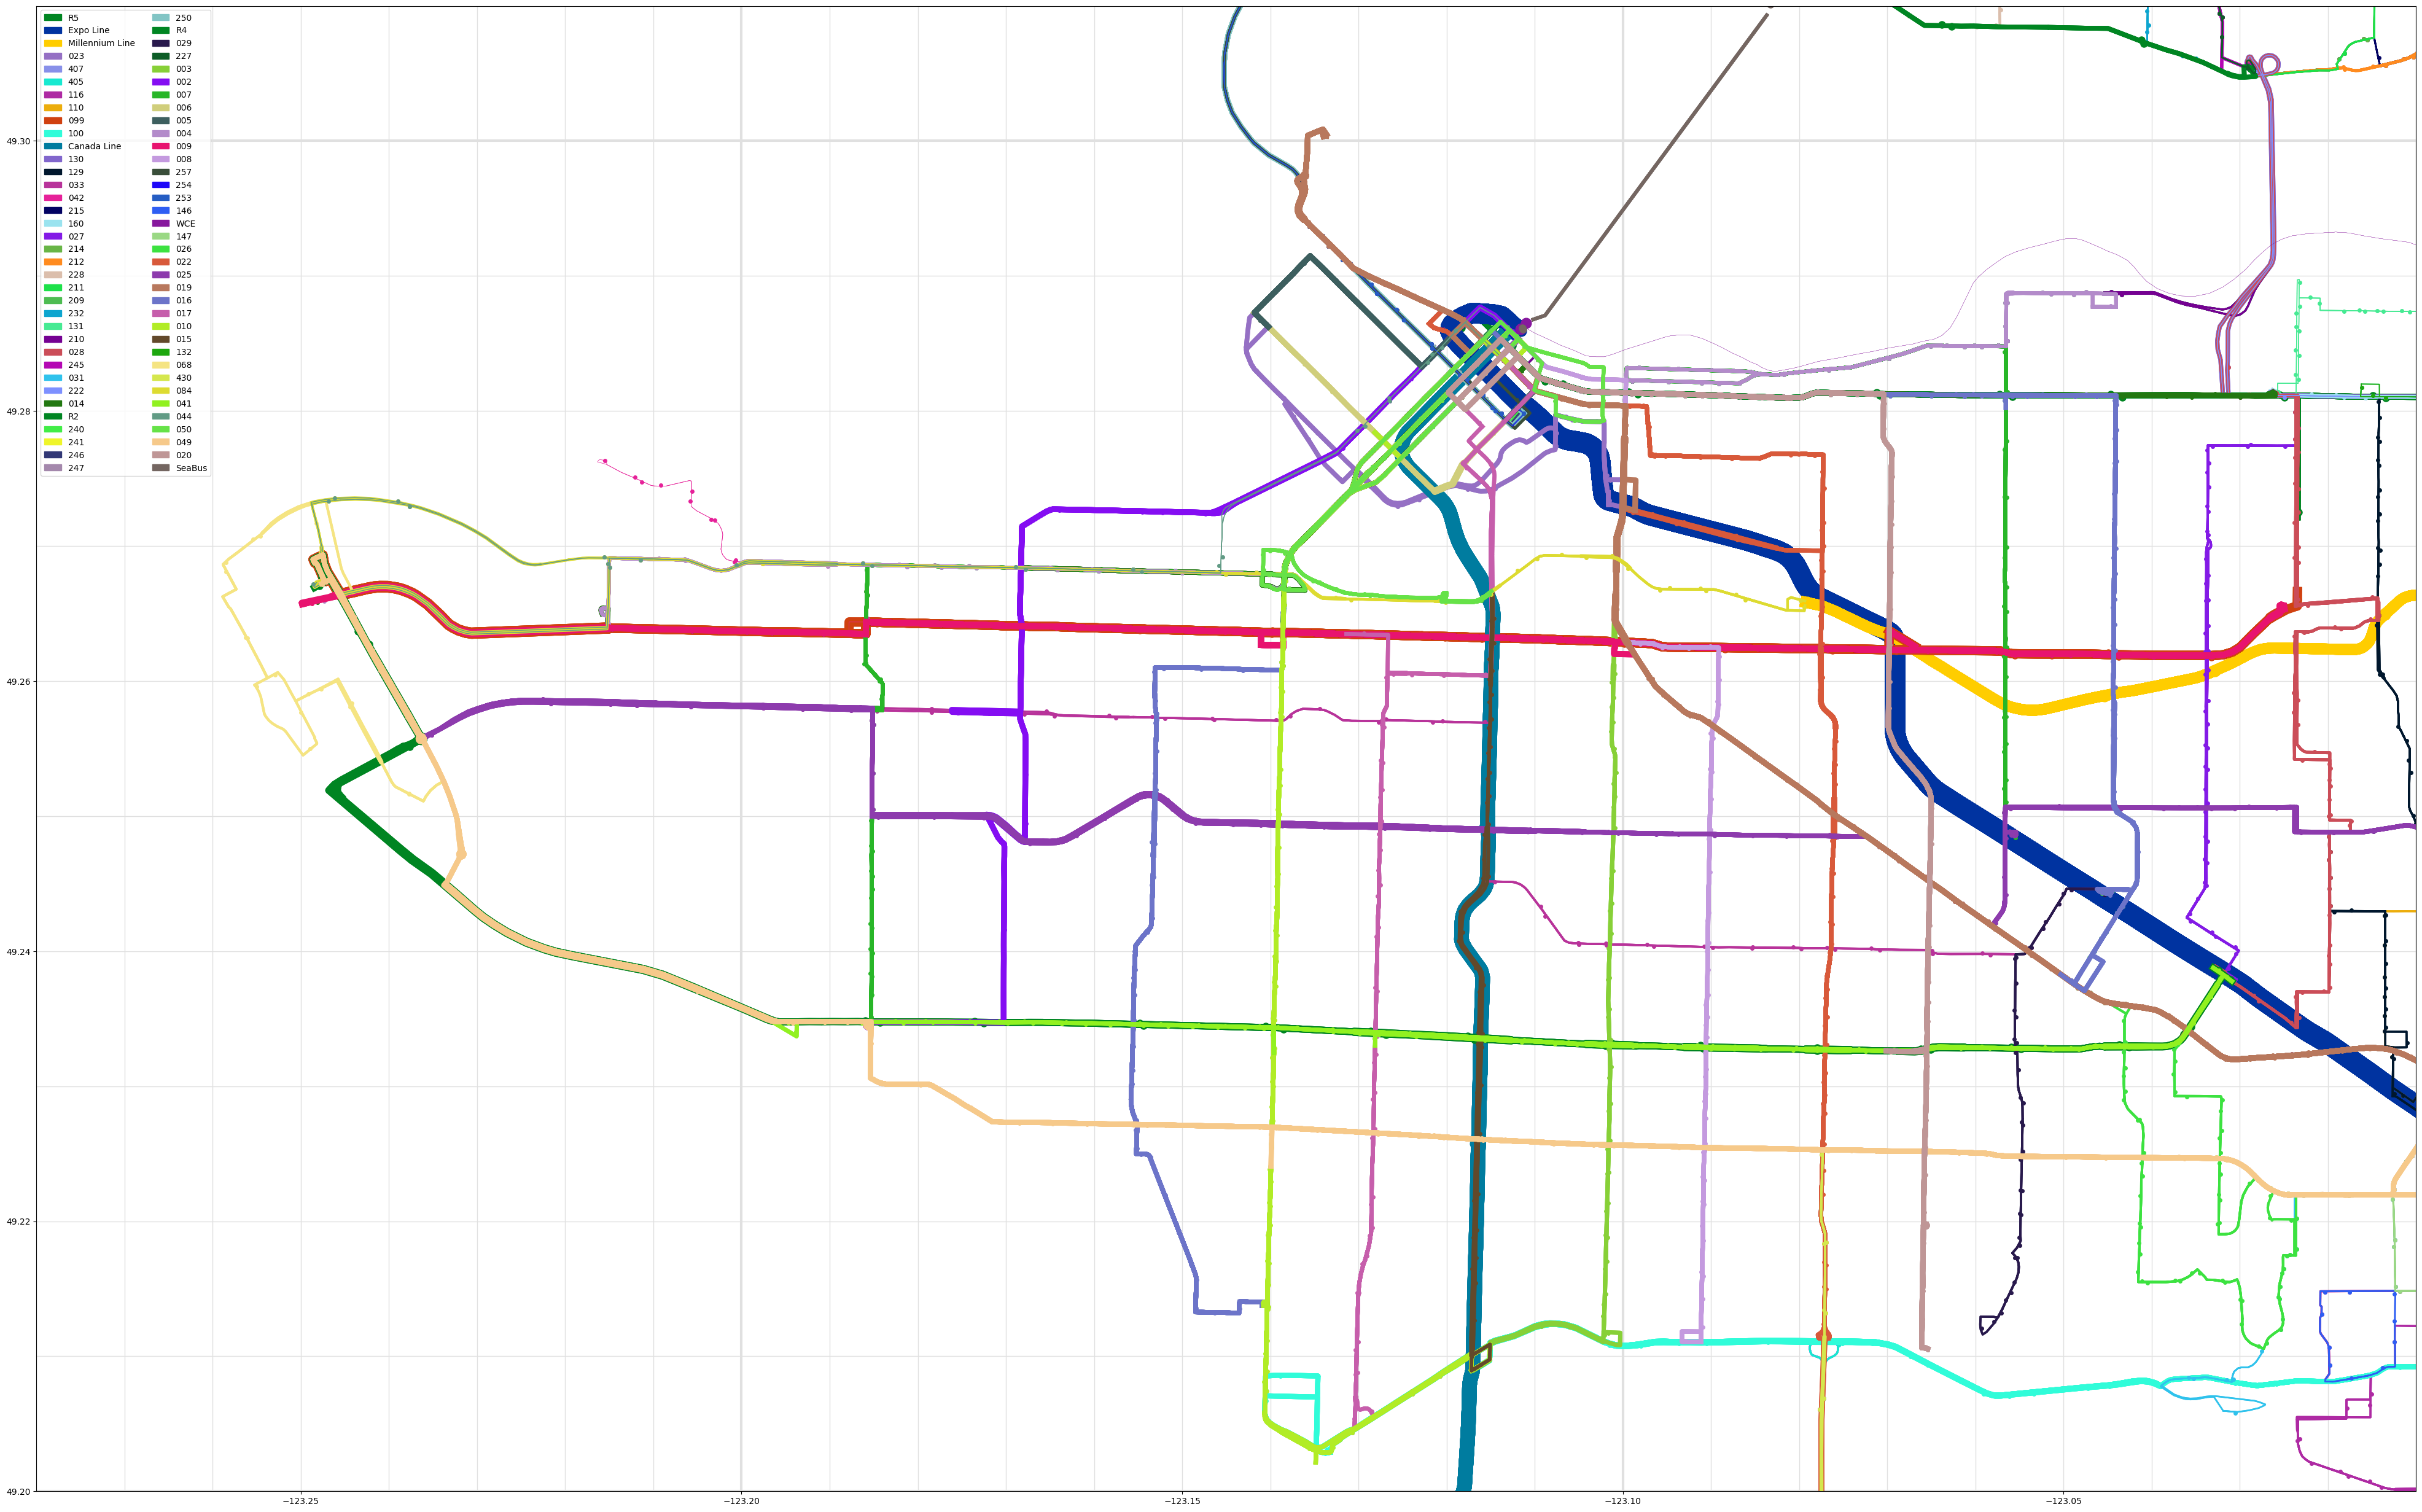

In [58]:
plot_routes(vancouver, night=False, stop_labels=False, plot_size=50, gridlines=True)

c:\Users\rayng\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


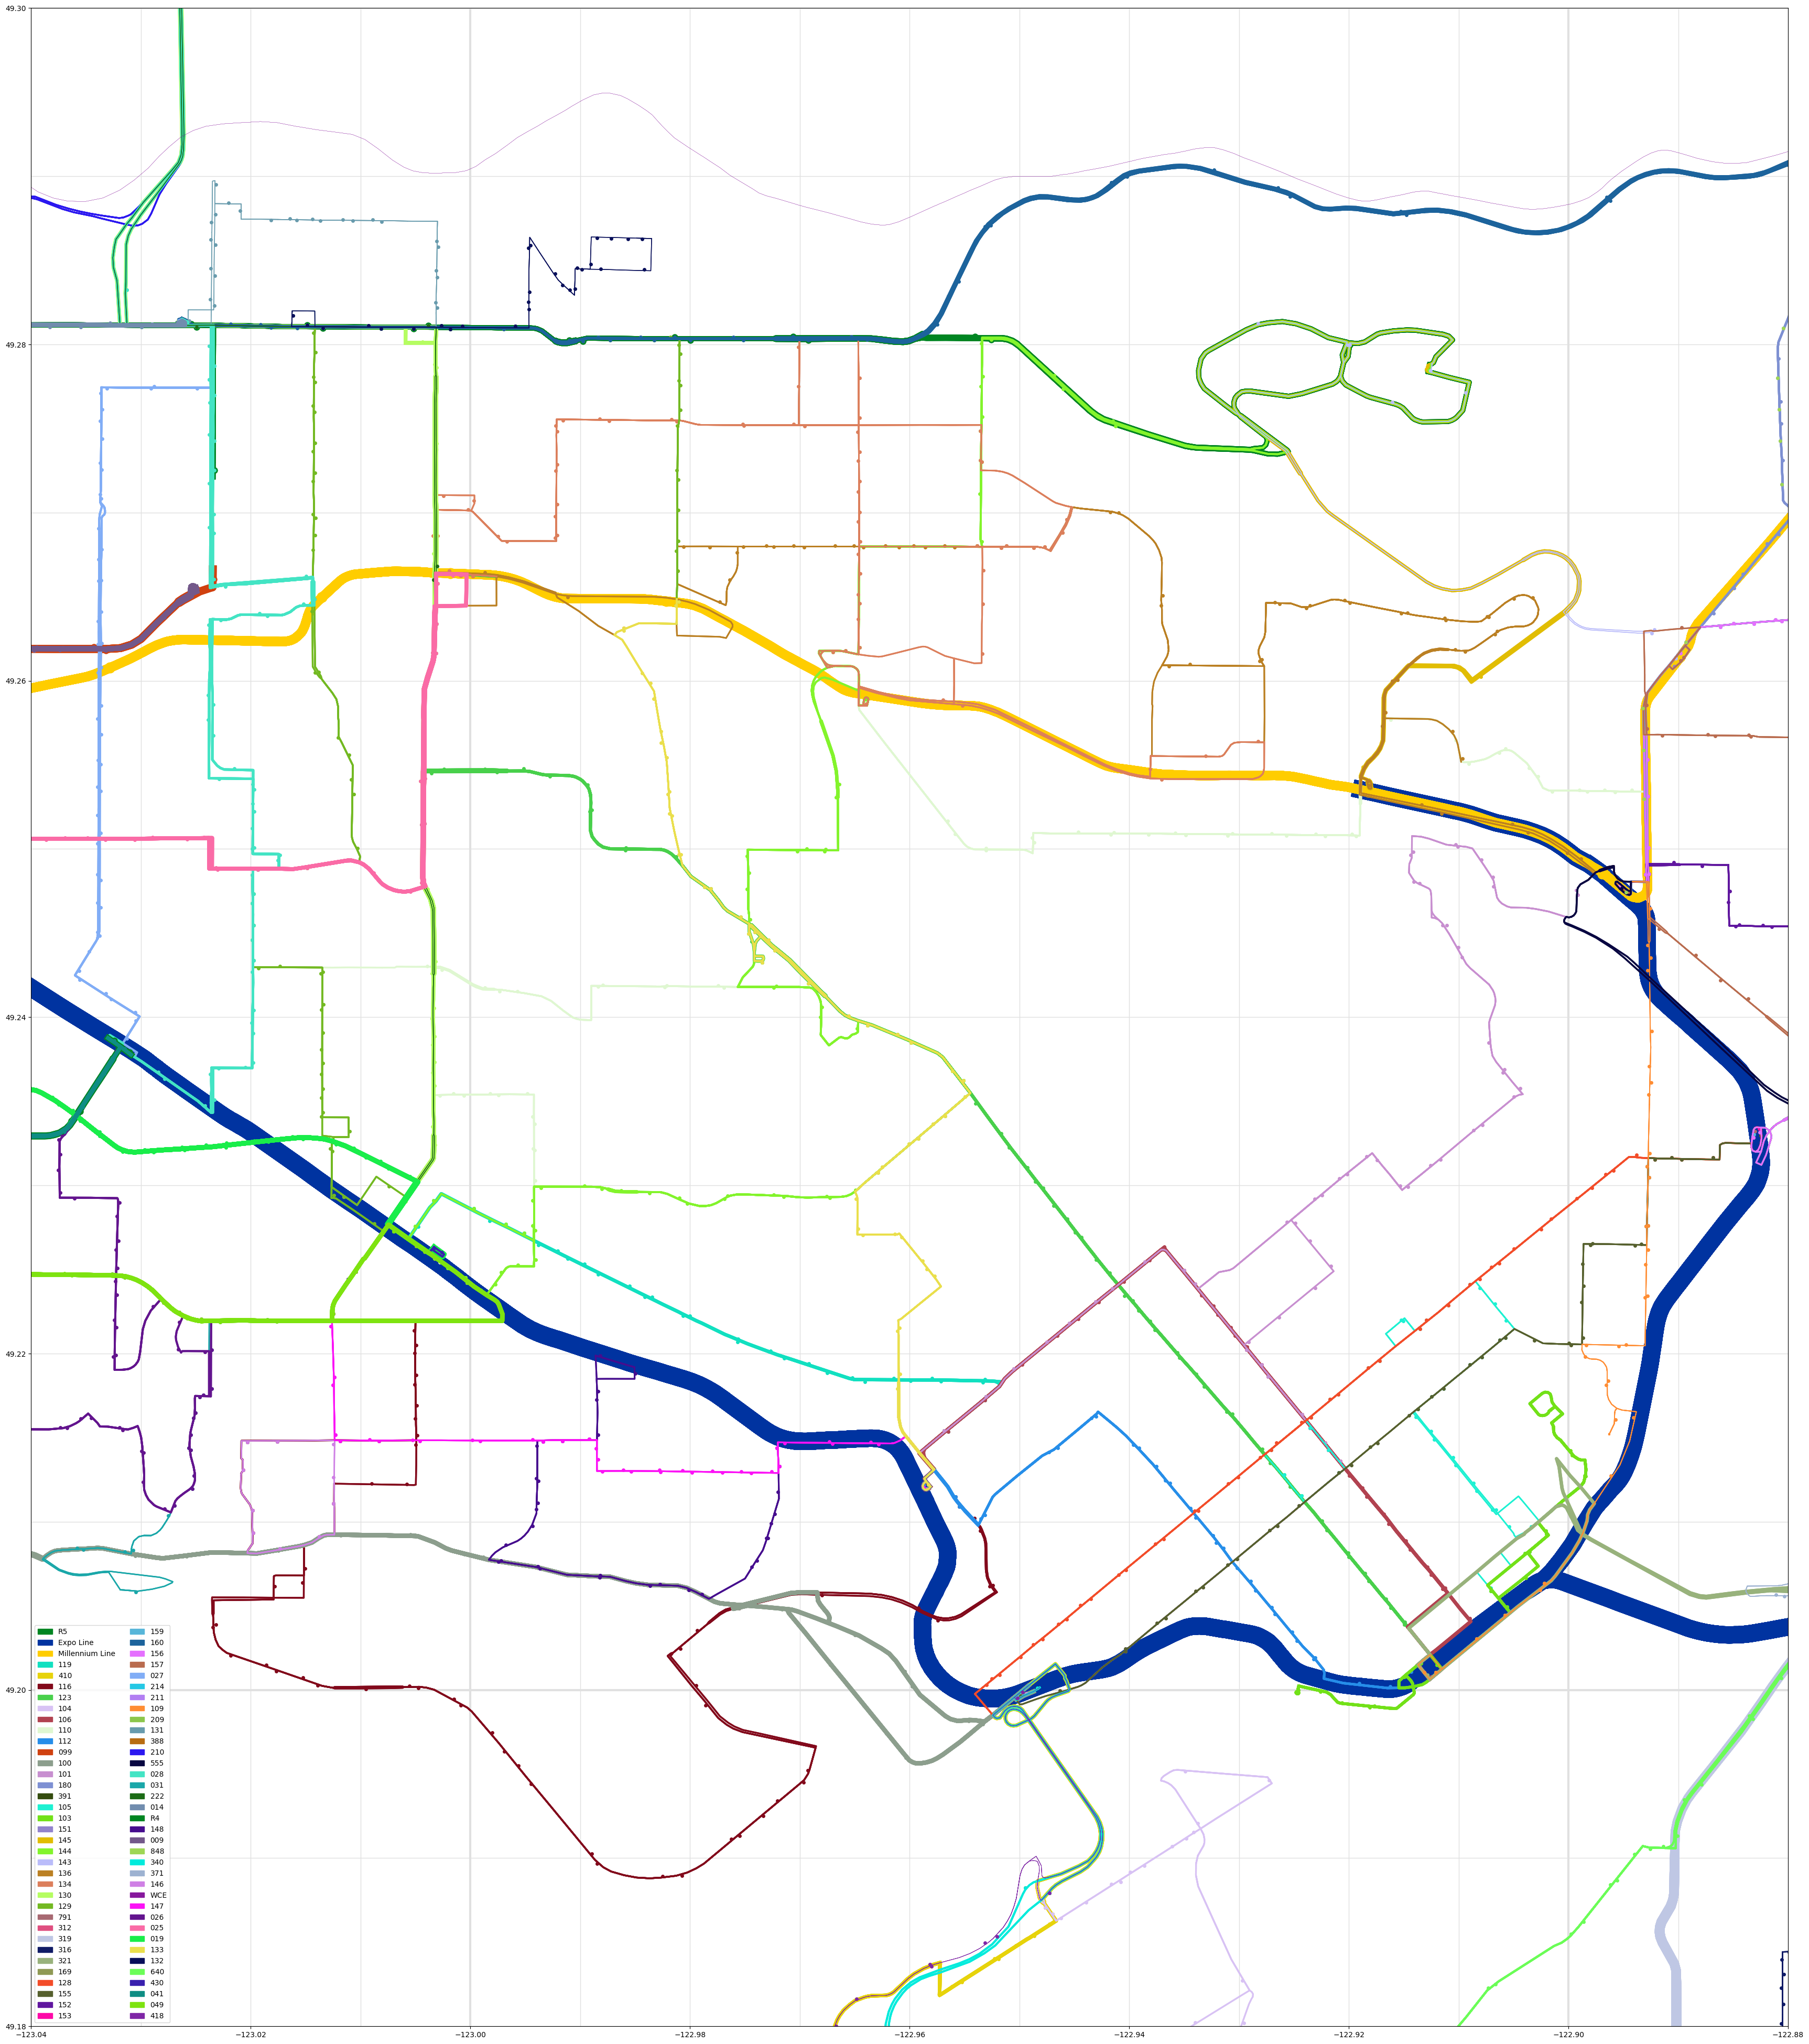

In [59]:
plot_routes(burnaby, night=False, stop_labels=False, plot_size=50, gridlines=True)

c:\Users\rayng\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


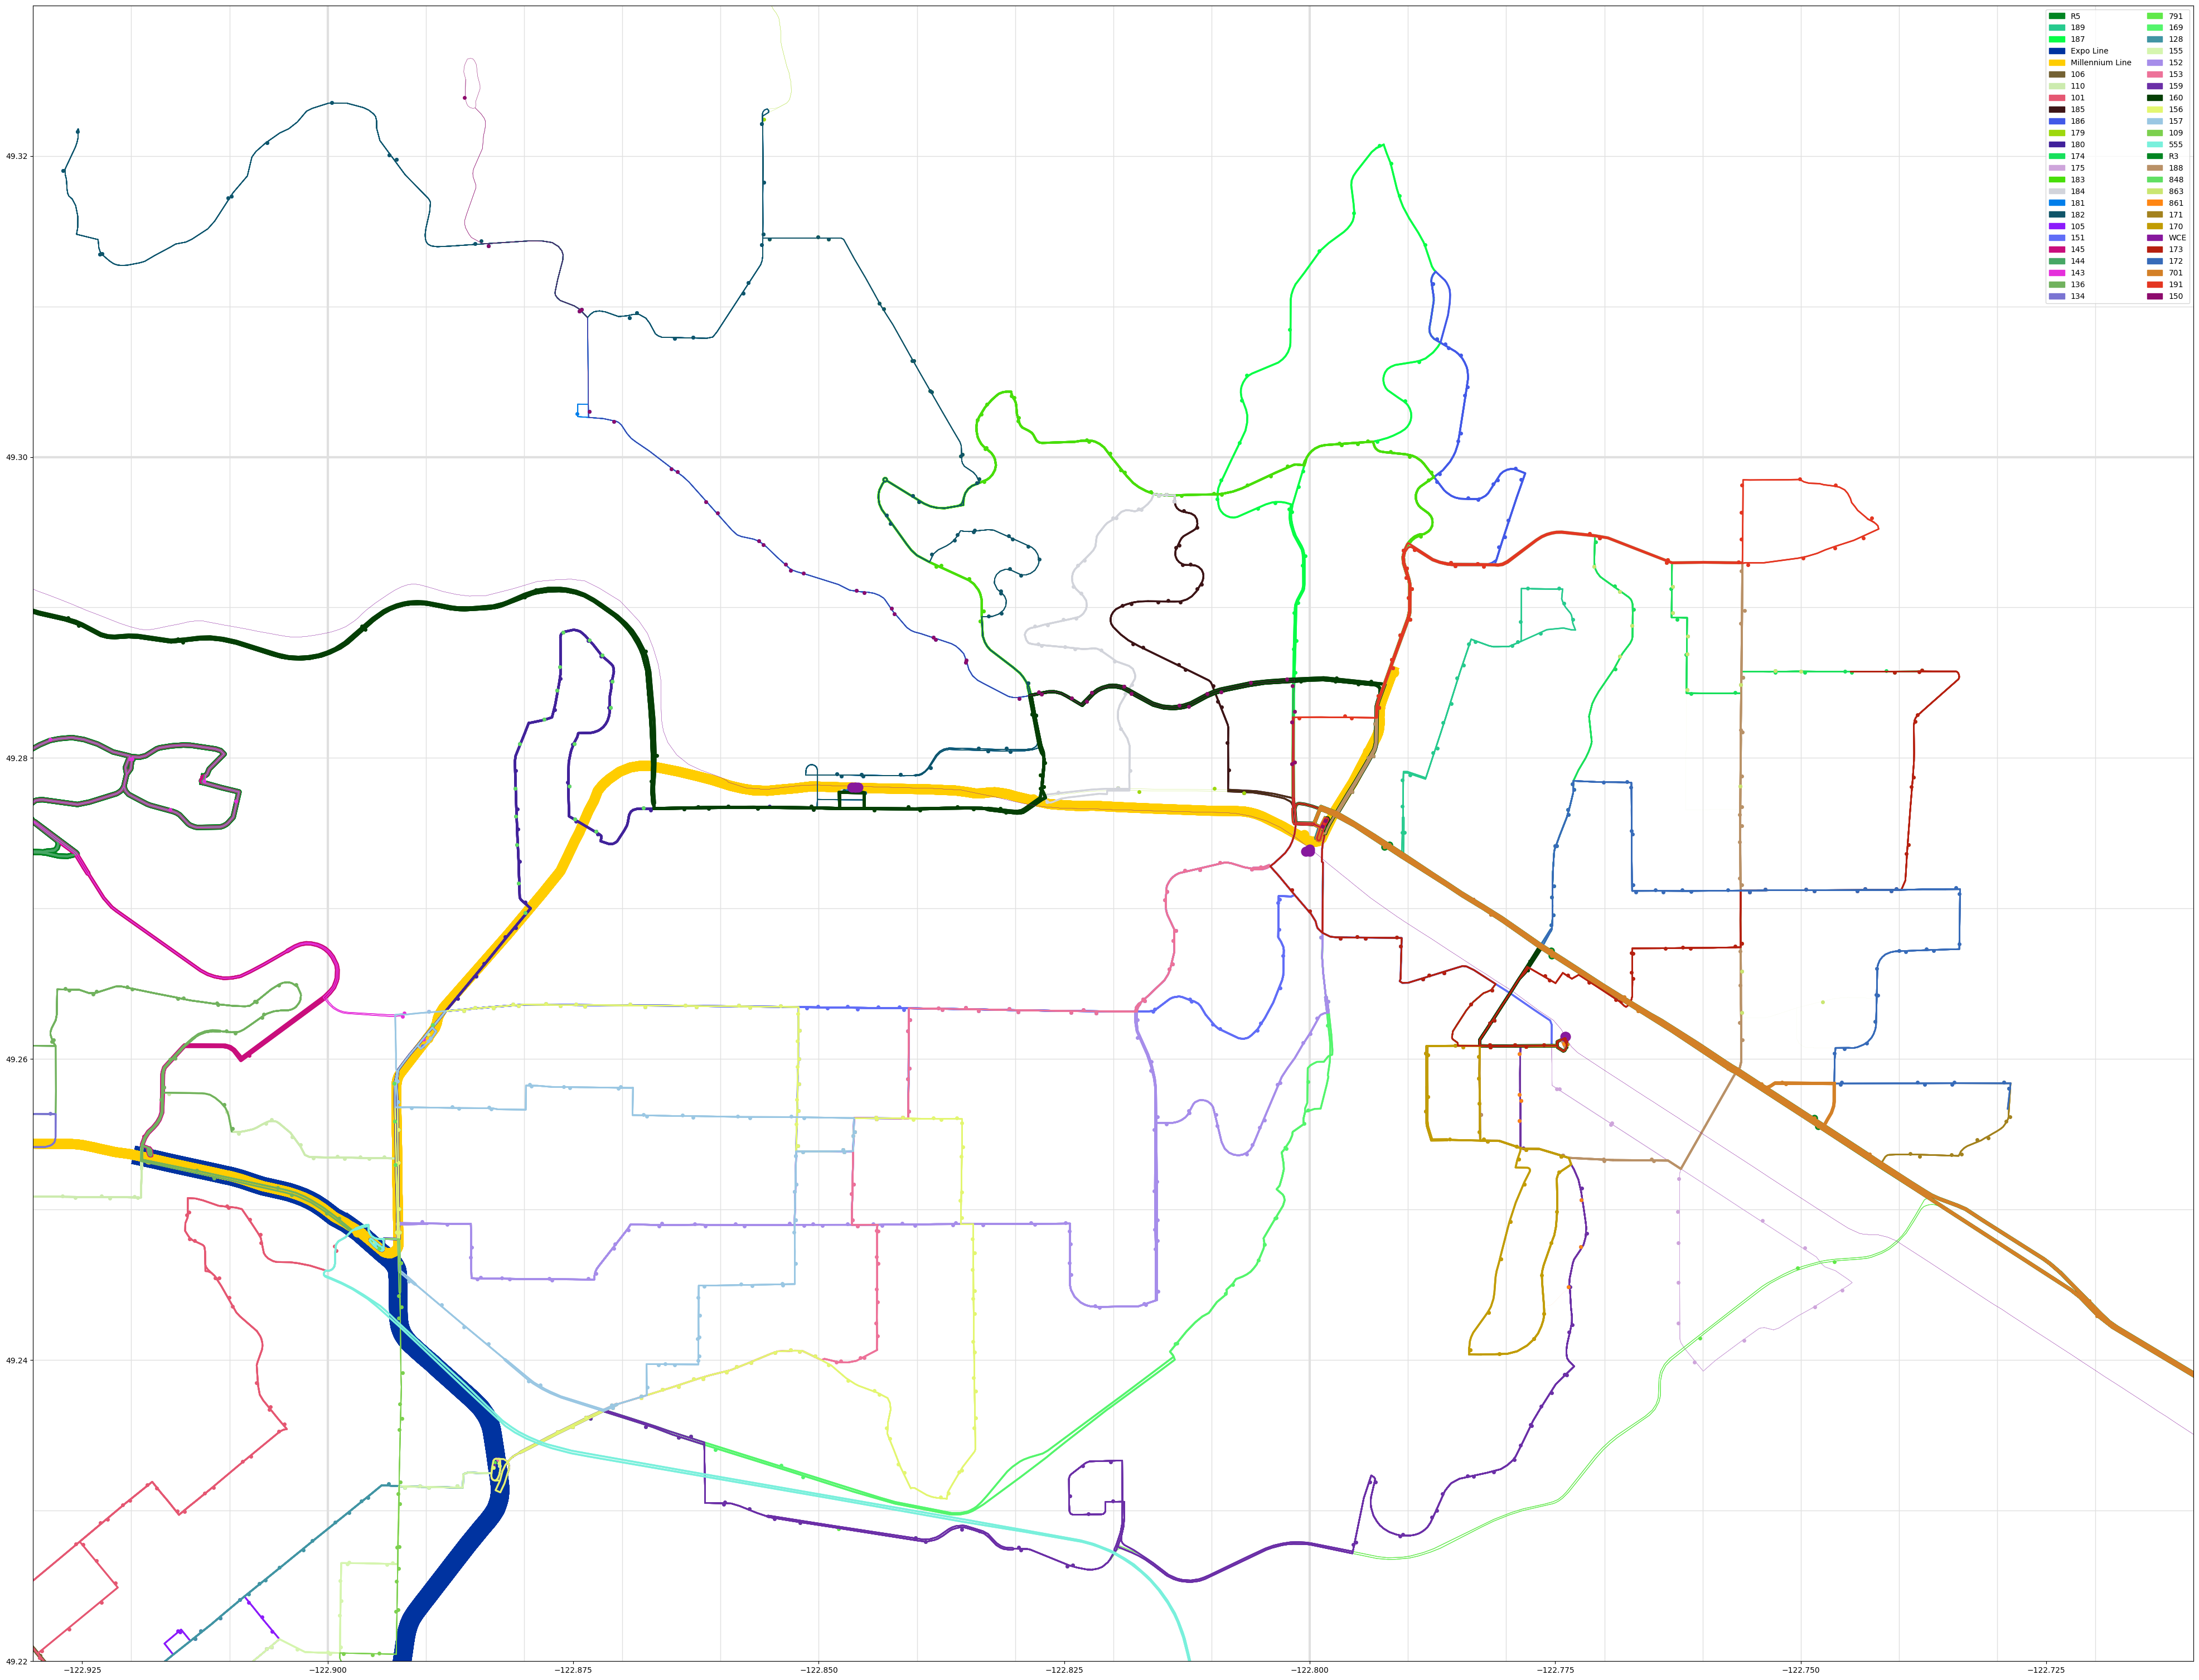

In [60]:
plot_routes(coquitlam, night=False, stop_labels=False, plot_size=50, gridlines=True)

c:\Users\rayng\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


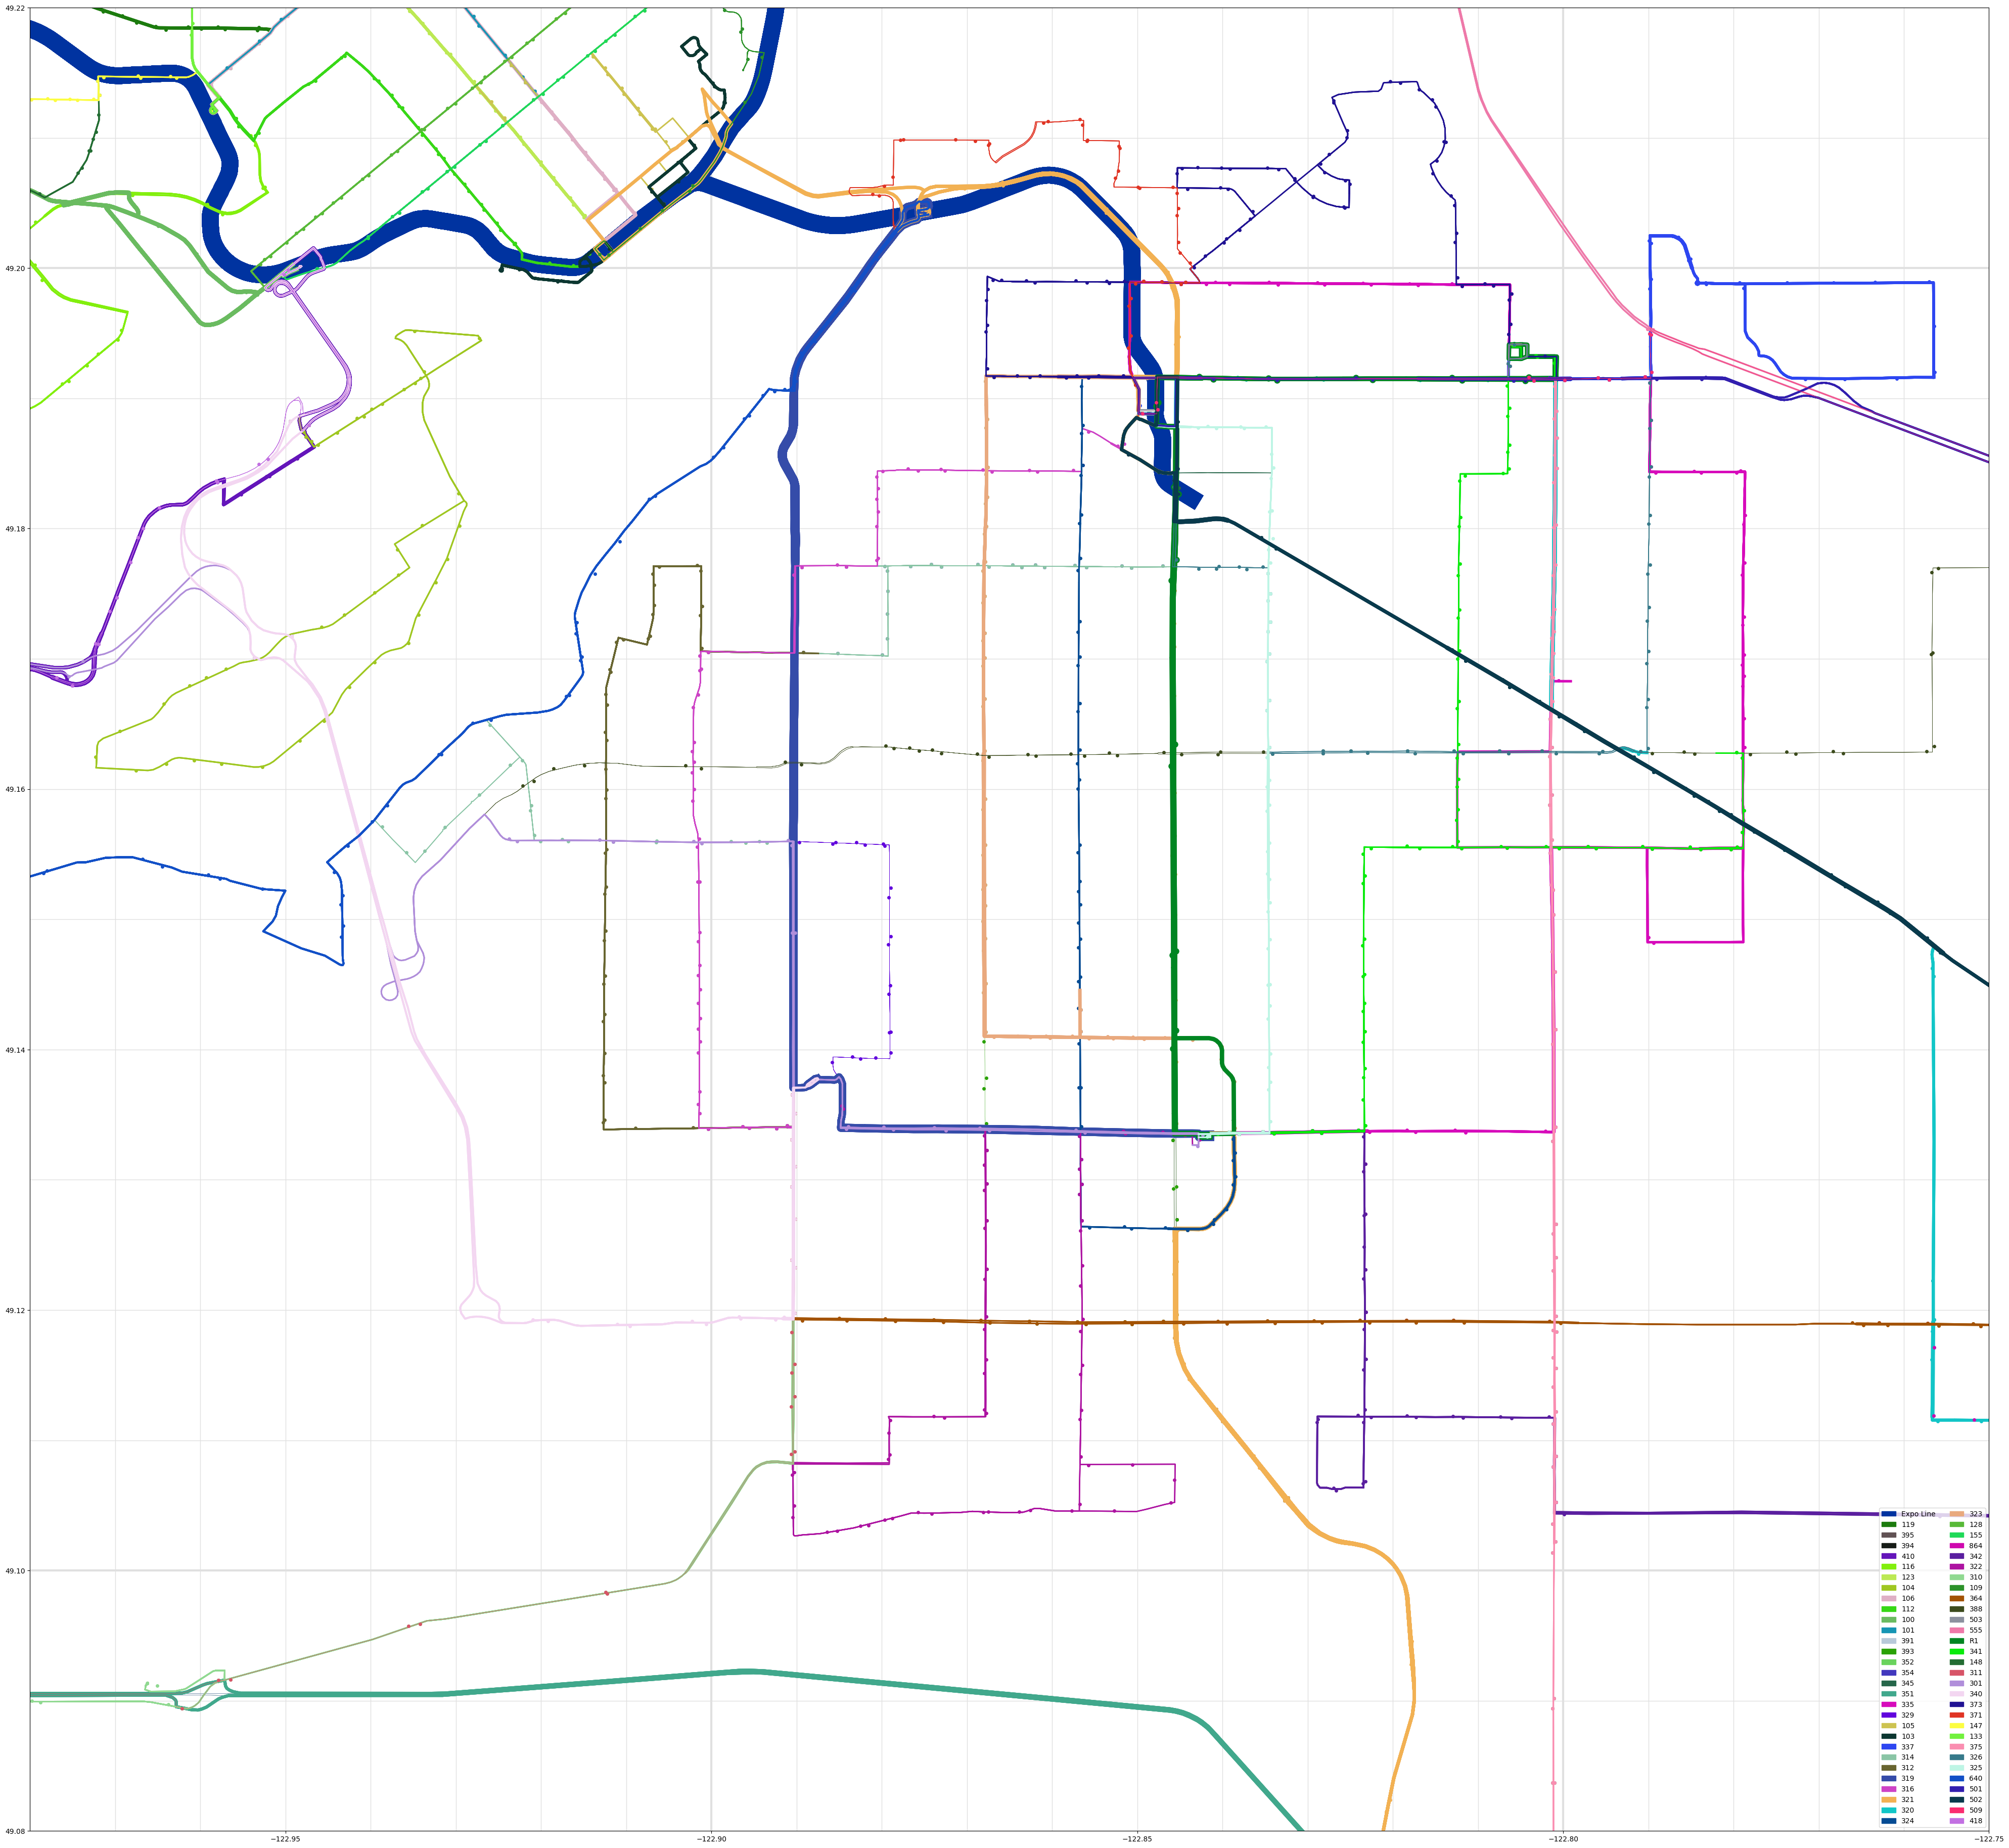

In [61]:
plot_routes(surrey, night=False, stop_labels=False, plot_size=50, gridlines=True)

c:\Users\rayng\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


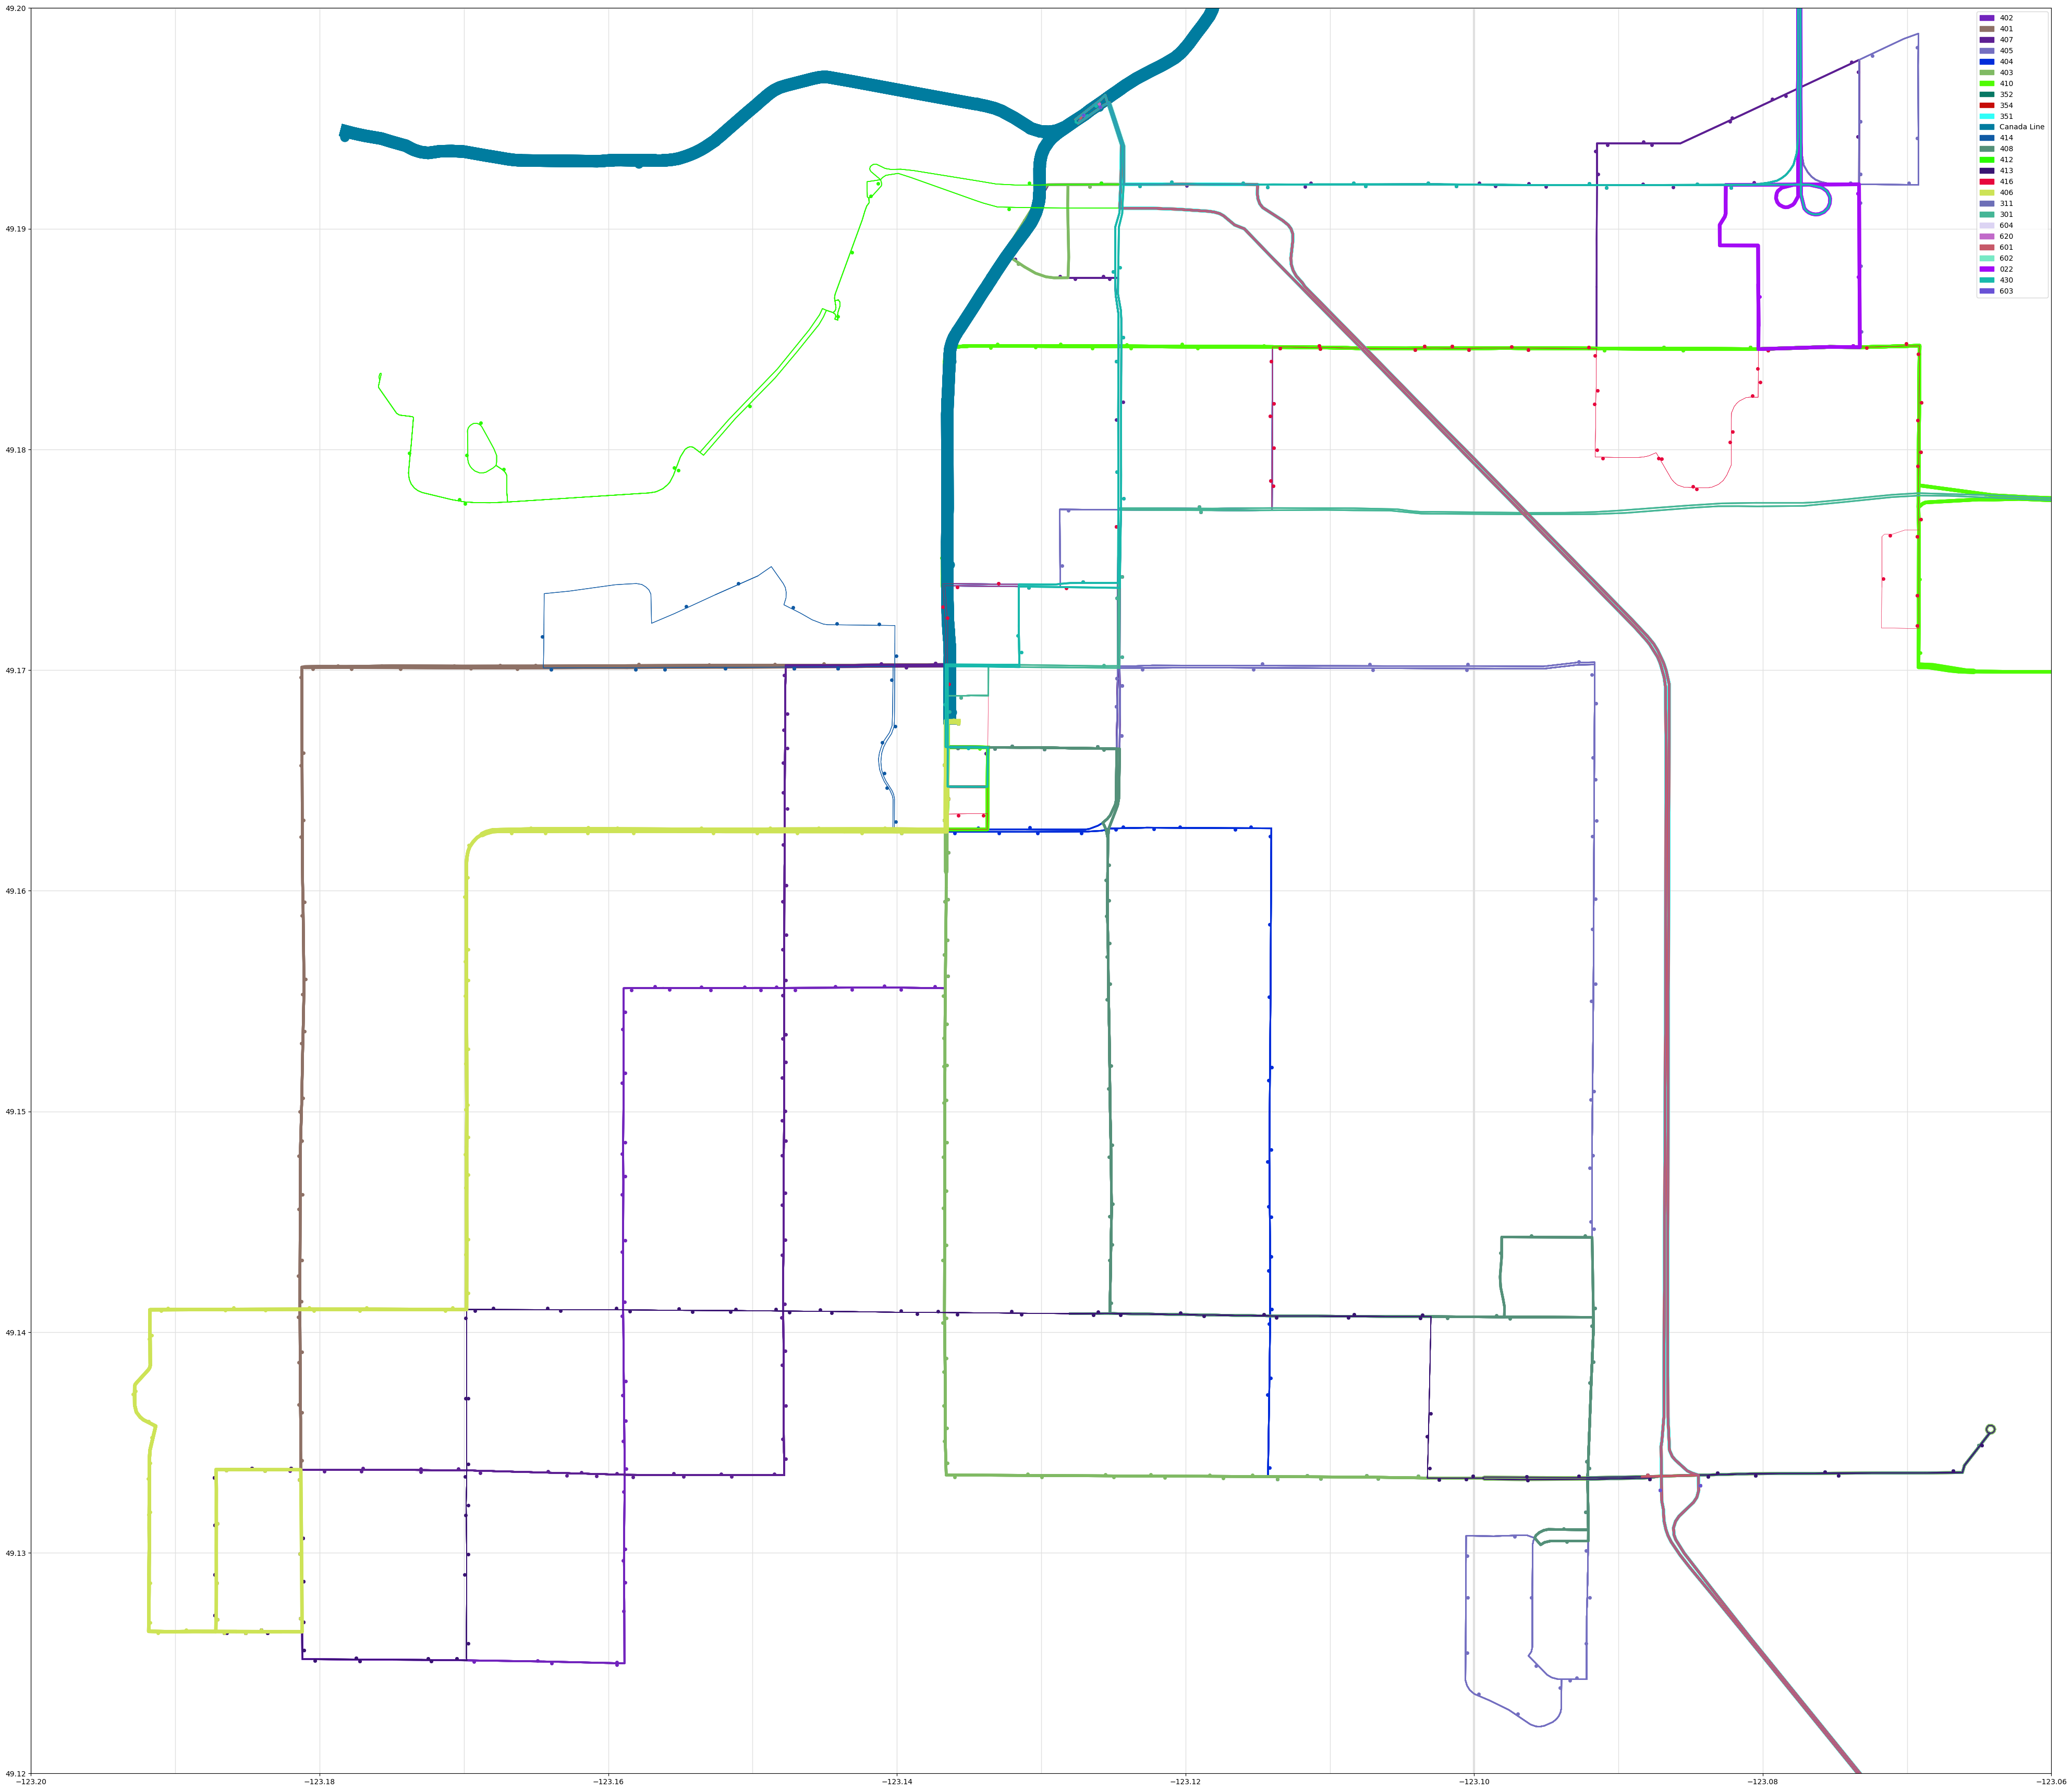

In [62]:
plot_routes(richmond, night=False, stop_labels=False, plot_size=50, gridlines=True)

c:\Users\rayng\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


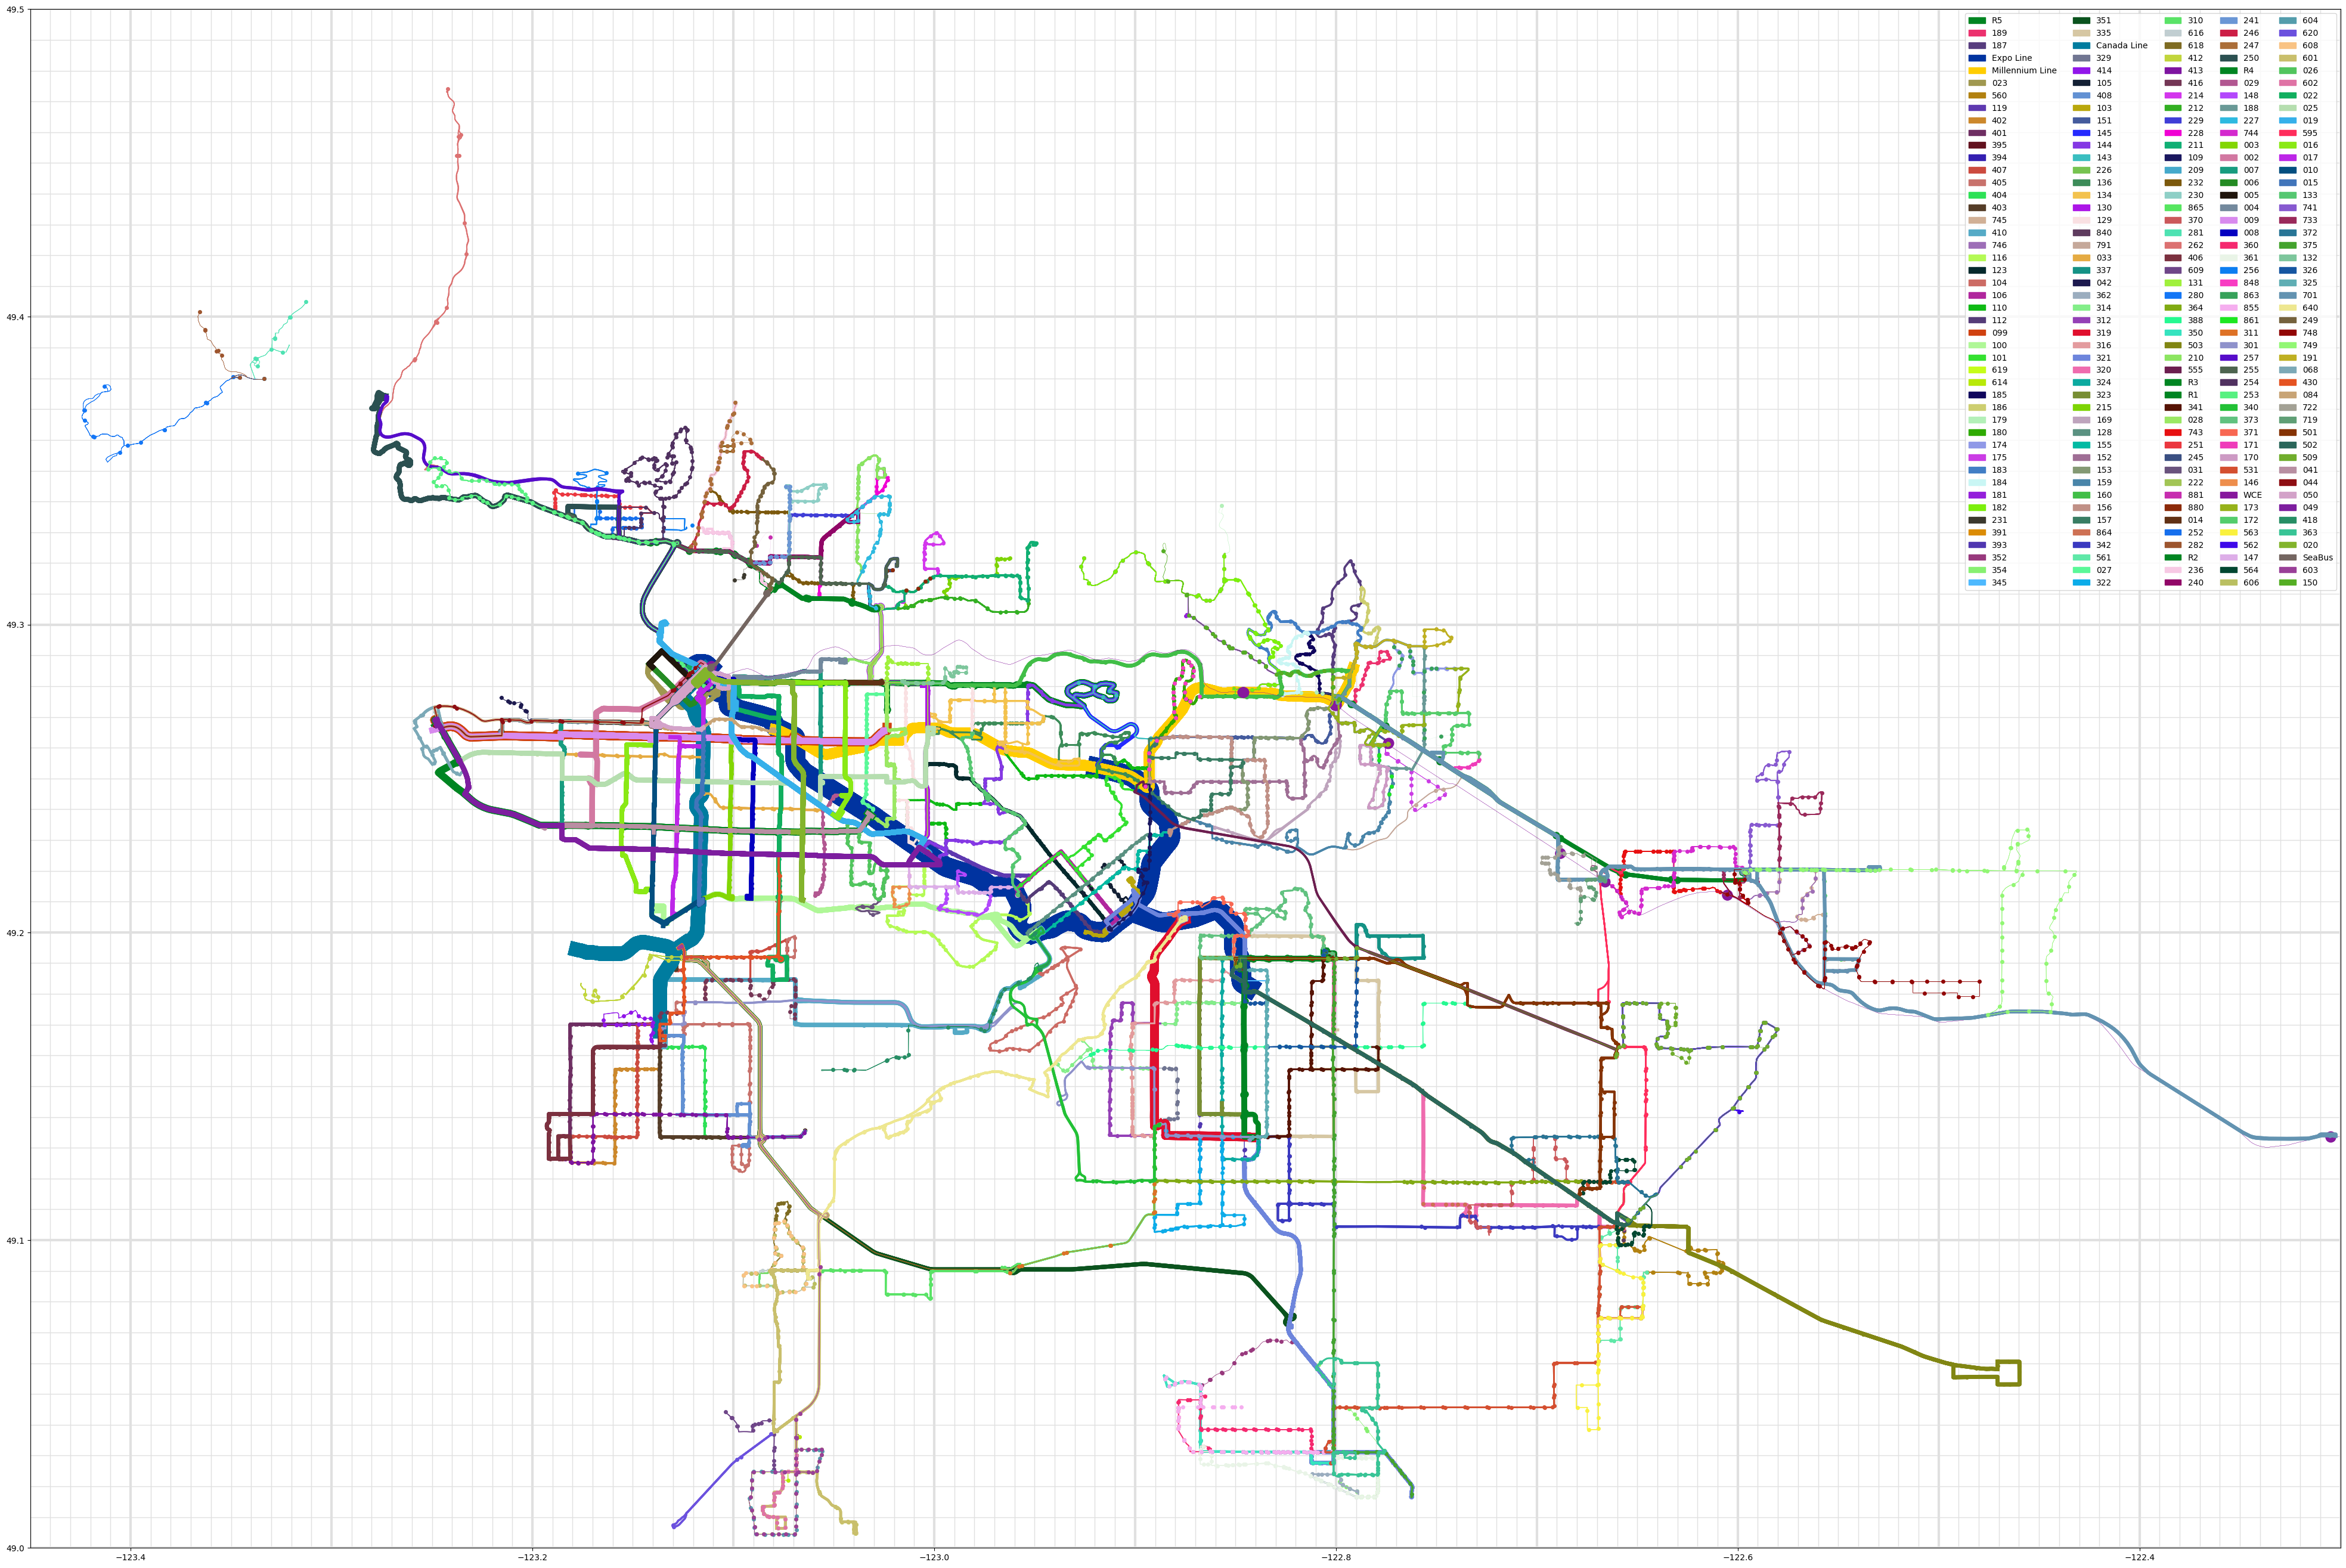

In [63]:
plot_routes(complete, night=False, stop_labels=False, plot_size=50, gridlines=True)

Plot all routes in Downtown Vancouver, with stop labels included

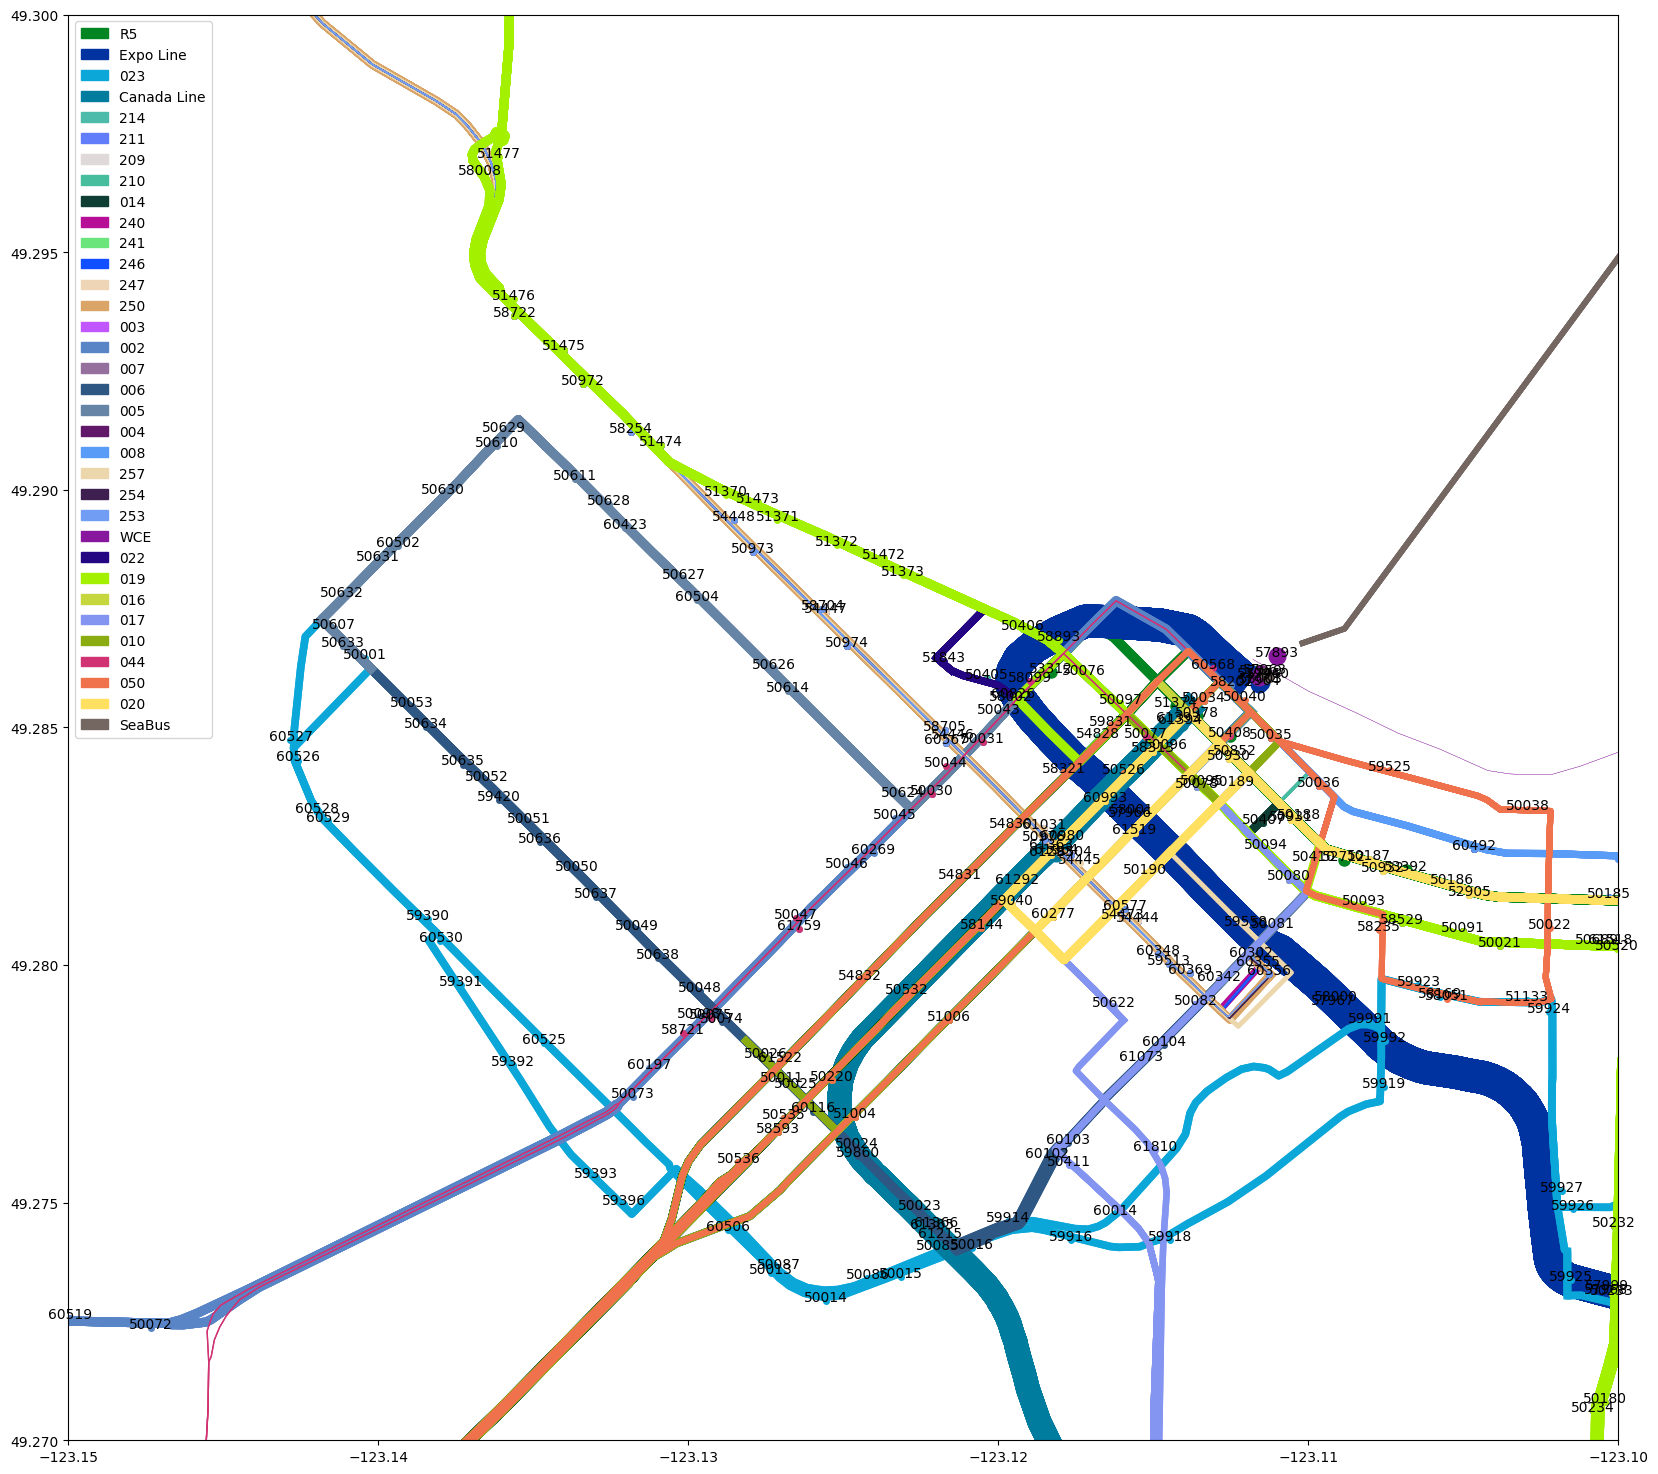

In [64]:
plot_routes(dt_vancouver, night=False, stop_labels=True)

Plot selected routes, e.g. routes to and from UBC

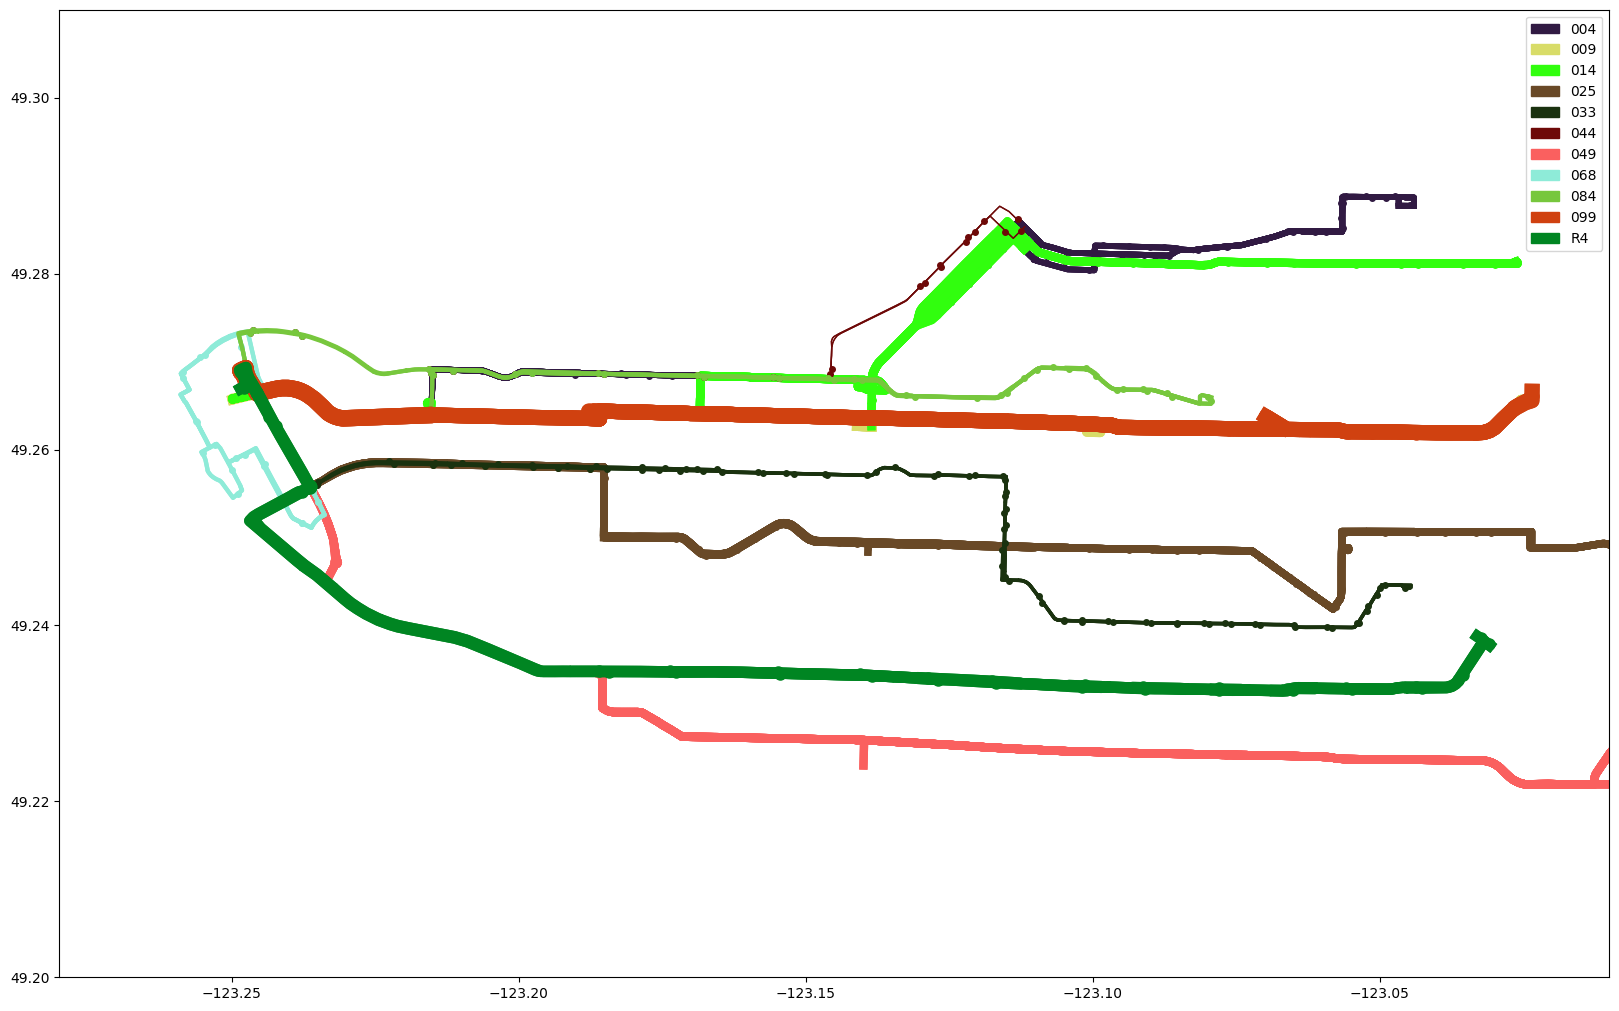

In [65]:
routes_selected = [4,9,14,25,33,44,49,68,84,99,'R4']
routes_to_plot = [route_lookup[route] for route in routes_selected]
plot_routes(vancouver, plotted_routes=routes_to_plot, night=False, shake=0.0000)

Plot all night routes in Vancouver

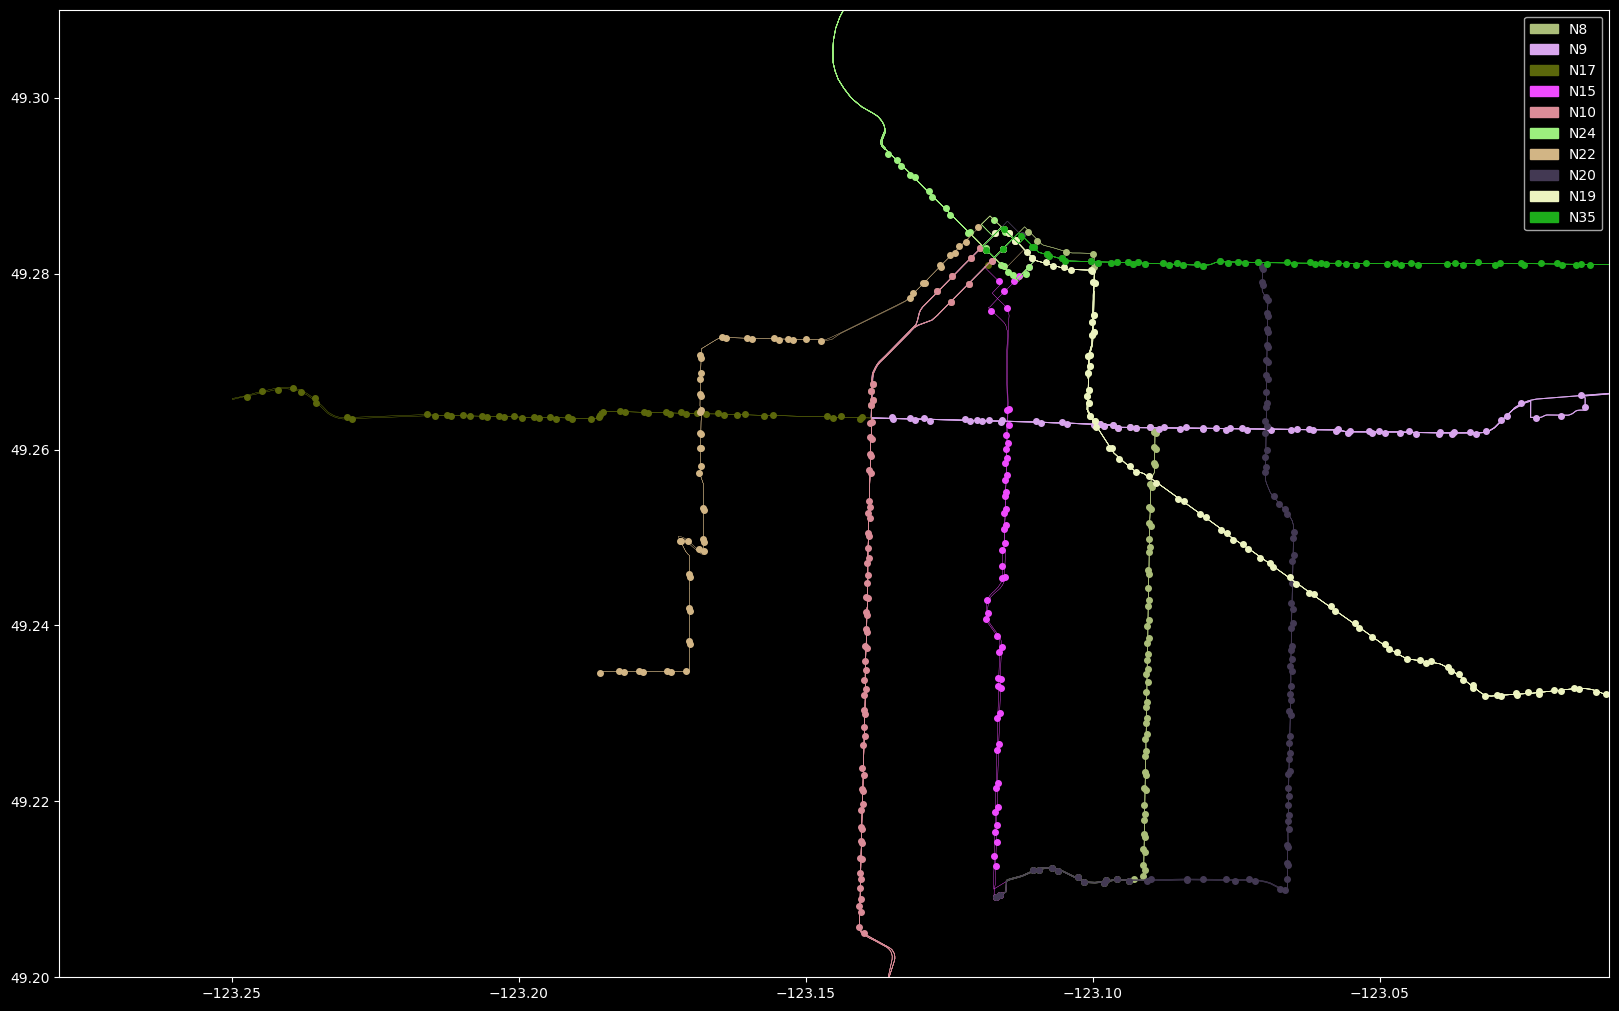

In [66]:
plot_routes(vancouver, night=True)

Plot daytime routes in Vancouver served on Mondays

c:\Users\rayng\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


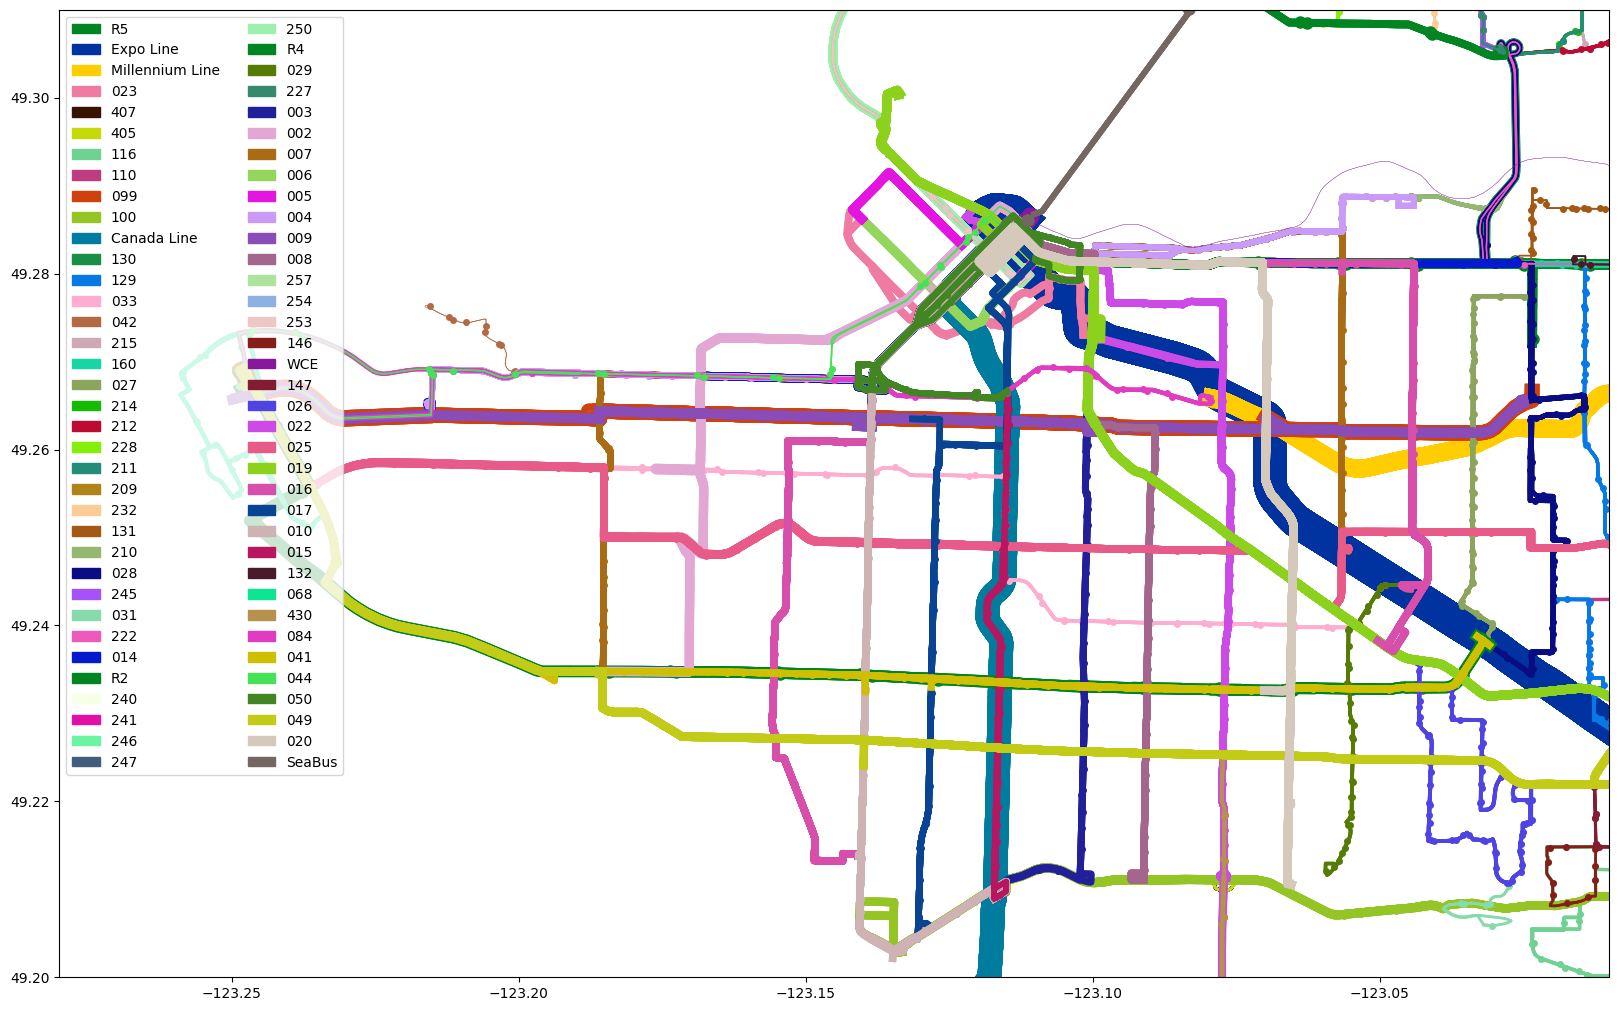

In [67]:
plot_routes(vancouver, weekday=0)

Plot daytime routes in Vancouver served on April 29, 2022

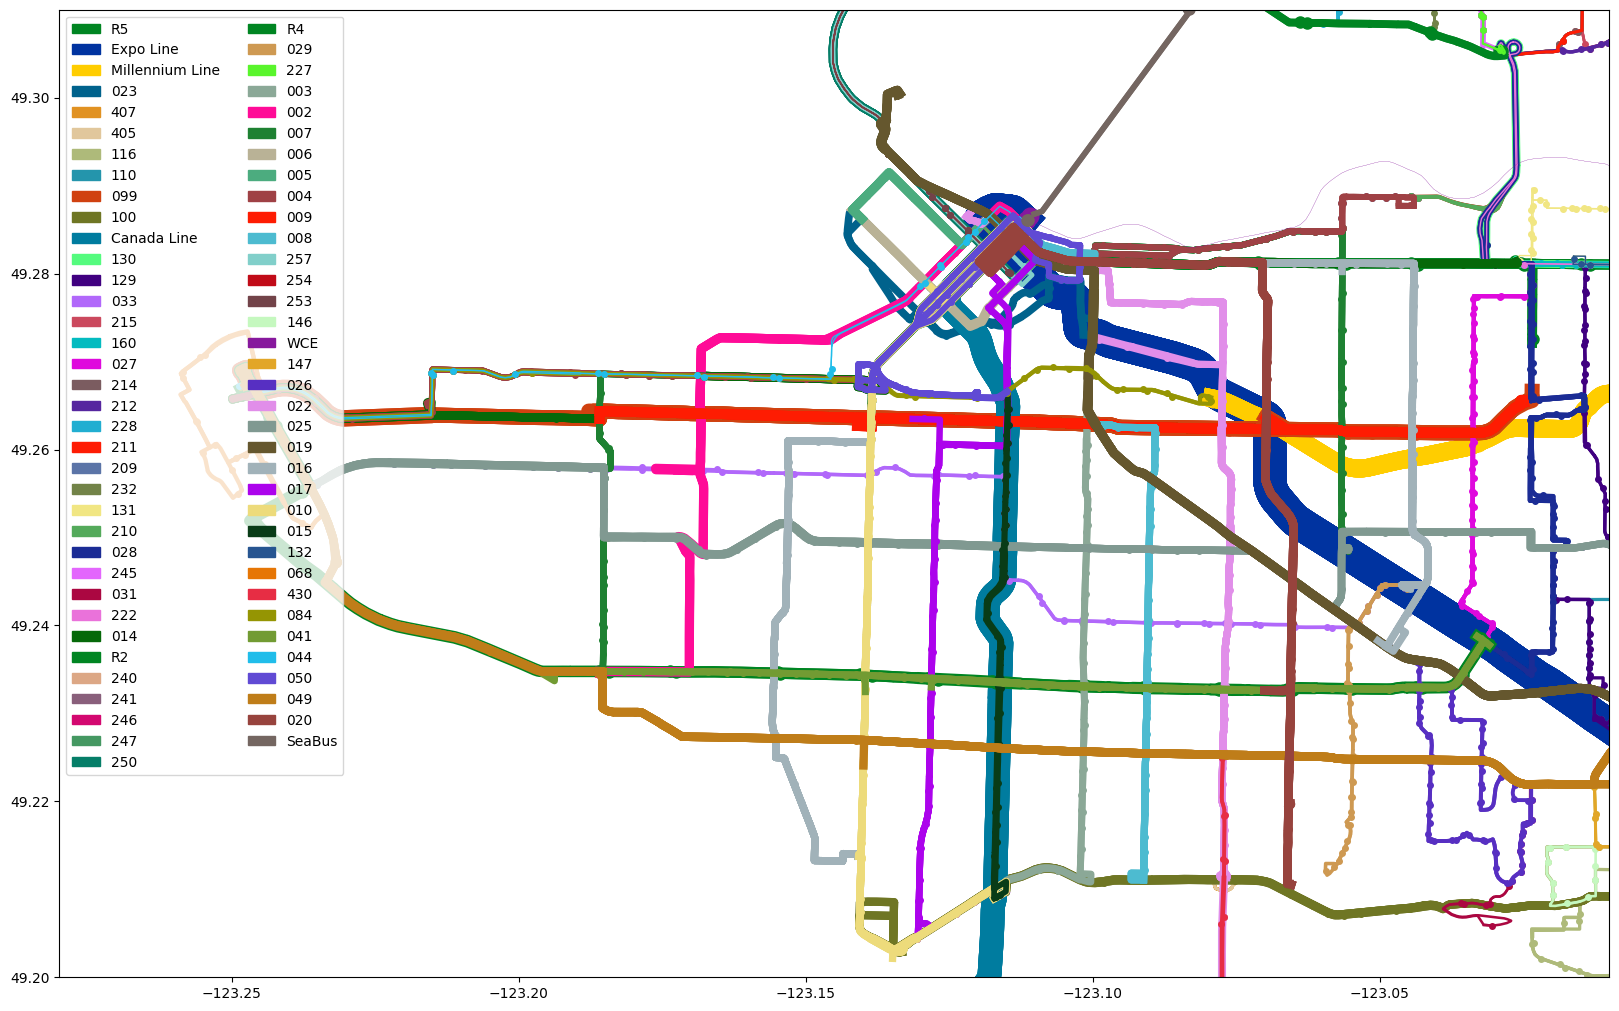

In [68]:
plot_routes(vancouver, date=20220429)

Helper function to process times - give the second of the day given a time e.g. 14:23:29 -> 51809

In [69]:
def time_to_second(time):
    hour = int(time[0:2])
    minute = int(time[3:5])
    second = int(time[6:8])

    return hour * 3600 + minute * 60 + second

Helper function to generate a topological ordering of a graph using Kahn's algorithm

In [70]:
def topological_ordering(graph):
    order = []

    predecessors = {node: 0 for node in graph}
    for node in graph:
        for next_node in graph[node]:
            predecessors[next_node] += 1
    
    while len(order) < len(graph):
        exists_cyclic = True
        for node in graph:
            if node not in order and predecessors[node] == 0:
                order.append(node)
                for next_node in graph[node]:
                    predecessors[next_node] -= 1
                exists_cyclic = False
                break
        if exists_cyclic:
            for node in graph:
                if node not in order:
                    order.append(node)
                    for next_node in graph[node]:
                        predecessors[next_node] -= 1
                    break

    return order

Generate a timetable given a route, a direction, day of week and/or date (optional)

In [71]:
def route_timetable(route_id, direction, weekday=None, date=None, trips_per_page=None):
    if date != None:
        try:
            current_date = date_string_to_date(date)
            weekday = current_date.weekday()
        except:
            pass
    
    route = routes[route_id]
    filtered_trips = []

    # Step 1: Filter trips into only trips serviced on the specified weekday and/or date
    for trip_id in route.trips:
        trip = trips[trip_id]

        if trip.direction == direction:
            available = service_available(trip_id, date, weekday)
                            
            if available:
                filtered_trips.append(trip_id)

    # Step 2: Generate a route graph and find a topological ordering for the generated graph if possible
    route_graph = {}

    for trip_id in filtered_trips:
        stop_times = trips[trip_id].stop_times
        prev_stop = None
        for stop in stop_times:
            stop_id = stop.stop_id

            if stop_id not in route_graph:
                route_graph[stop_id] = []
            if prev_stop != None:
                if stop_id not in route_graph[prev_stop]:
                    route_graph[prev_stop].append(stop_id)
            prev_stop = stop_id

    stop_order = topological_ordering(route_graph)

    # Step 3: Arrange trips in order of first stop
    trip_order = [None for trip in filtered_trips]

    for trip in filtered_trips:
        order = 0
        for trip2 in filtered_trips:
            time1 = time_to_second(trips[trip].stop_times[0].departure)
            time2 = time_to_second(trips[trip2].stop_times[0].departure)
            if time1 > time2:
                order += 1
        while trip_order[order] != None:
            order += 1
        trip_order[order] = trip

    # Step 4: Rearrange trips using topological ordering
    successors = {trip: [] for trip in trip_order}

    for trip1 in trip_order:
        for trip2 in trip_order:
            successive = False
            for stop in stop_order:
                time1 = None
                for stop_time in trips[trip1].stop_times:
                    if stop_time.stop_id == stop:
                        time1 = time_to_second(stop_time.departure)
                
                time2 = None
                for stop_time in trips[trip2].stop_times:
                    if stop_time.stop_id == stop:
                        time2 = time_to_second(stop_time.departure)
                
                if time1 != None and time2 != None and time2 > time1:
                    successive = True
            if successive:
                successors[trip1].append(trip2)

    new_trip_order = topological_ordering(successors)

    # Step 5: Assemble the timetable
    timetable = {stop: [] for stop in stop_order}

    for trip in new_trip_order:
        for stop in timetable:
            timetable[stop].append(None)
        
        stop_times = trips[trip].stop_times

        for stop in stop_times:
            stop_id = stop.stop_id
            time = stop.departure
            timetable[stop_id][-1] = time

    # Step 6: Print the timetable from the dictionary
    timetable_string = ''''''

    weekday_str = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    if date != None:
        timetable_string += datetime.date(date // 10000, (date % 10000 // 100), date % 100).strftime('%A %d %B %Y') + '\n'
    elif weekday != None:
        timetable_string += weekday_str[weekday] + '\n'
    timetable_string += str(route.short_name) + ' ' + str(route.long_name) + ' ' + str(route.directions[direction]) + '\n'

    if len(timetable) > 0:
        number_of_trips = len(list(timetable.values())[0])
        index = 0
        max_length = max([len(stops[stop].name) for stop in timetable])
        if trips_per_page == None:
            trips_per_page = max(1, (110-max_length-6) // 10)
        pages = (number_of_trips - 1) // trips_per_page + 1
        page = 1

        while index < number_of_trips:
            timetable_string += '\n(Page {} of {})\n\n'.format(page, pages)

            for stop in timetable:
                line = ''
                line += str(stops[stop].code) + ' ' + stops[stop].name.ljust(max_length) + '  '
                for time in timetable[stop][index:index+trips_per_page]:
                    if time == None:
                        line += '--------  '
                    else:
                        line += time + '  '
                timetable_string += line + '\n'
                
            index += trips_per_page
            page += 1

    elif len(timetable) == 0:
        timetable_string += '\nNo services available for this route on this day.'

    return timetable_string

In [72]:
route = route_lookup[49]
direction = 0
print(route_timetable(route, direction, date=20220430))

Saturday 30 April 2022
049 Metrotown Station/Dunbar Loop/UBC EAST

(Page 1 of 16)

60163 UBC Exchange @ Bay 5                           --------  --------  --------  --------  --------  
51479 Southbound Wesbrook Mall @ Agronomy Rd         --------  --------  --------  --------  --------  
51480 Southbound Wesbrook Mall @ Thunderbird Blvd    --------  --------  --------  --------  --------  
51483 Southbound Wesbrook Mall @ Hampton Place       --------  --------  --------  --------  --------  
61579 Southbound Wesbrook Mall @ Birney Ave          --------  --------  --------  --------  --------  
61581 Southbound Wesbrook Mall @ Triumf Centre       --------  --------  --------  --------  --------  
59489 Eastbound SW Marine Dr @ Wesbrook Mall         --------  --------  --------  --------  --------  
51887 Eastbound SW Marine Dr @ Kullahun Dr           --------  --------  --------  --------  --------  
51888 Eastbound W 41 Ave @ Crown St                  --------  --------  --------  --

Generate the timetable at each stop

In [73]:
def stop_timetable(stop, date=None, weekday=None):
    if date != None:
        try:
            current_date = date_string_to_date(date)
            weekday = current_date.weekday()
        except:
            pass
    
    stop_trips = stops[stop].trip_times
    filtered_trips = {}

    for trip in stop_trips:
        if service_available(trip, date, weekday):
            filtered_trips[trip] = stop_trips[trip]

    sorted_trips = [None for n in range(len(filtered_trips))]

    for trip in filtered_trips:
        rank = 0
        for trip2 in filtered_trips:
            if time_to_second(filtered_trips[trip2]) < time_to_second(filtered_trips[trip]):
                rank += 1
        
        while sorted_trips[rank] != None:
            rank += 1
        sorted_trips[rank] = trip
    
    timetable_string = str(stops[stop].code) + ' ' + stops[stop].name

    for trip in sorted_trips:
        timetable_string += '\n'
        timetable_string += filtered_trips[trip] + ' ' + trips[trip].headsign

    return timetable_string

In [74]:
print(stop_timetable(stop_lookup[50268], 20220429))

50268 Eastbound University Blvd @ Allison Rd
03:01:00 14 DOWNTOWN
03:31:00 14 DOWNTOWN
04:06:00 14 DOWNTOWN
04:36:00 14 HASTINGS
05:08:00 14 HASTINGS
05:33:00 14 HASTINGS
05:57:00 14 HASTINGS
06:12:00 14 HASTINGS
06:27:00 14 HASTINGS
06:28:54 99 COMM'L-BDWAY STN
06:36:54 99 COMM'L-BDWAY STN
06:41:06 14 HASTINGS
06:44:54 99 COMM'L-BDWAY STN
06:49:57 99 COMM'L-BDWAY STN
06:54:57 99 COMM'L-BDWAY STN
06:57:06 14 HASTINGS
06:59:57 99 COMM'L-BDWAY STN
07:04:57 99 COMM'L-BDWAY STN
07:08:57 99 COMM'L-BDWAY STN
07:09:50 4 POWELL
07:12:06 14 HASTINGS
07:12:57 99 COMM'L-BDWAY STN
07:16:02 99 COMM'L-BDWAY STN
07:19:02 99 COMM'L-BDWAY STN
07:22:02 99 COMM'L-BDWAY STN
07:24:50 4 POWELL
07:25:02 99 COMM'L-BDWAY STN
07:25:12 14 HASTINGS
07:28:02 99 COMM'L-BDWAY STN
07:31:05 99 COMM'L-BDWAY STN
07:34:05 99 COMM'L-BDWAY STN
07:37:05 99 COMM'L-BDWAY STN
07:37:12 14 HASTINGS
07:38:50 4 POWELL
07:40:05 99 COMM'L-BDWAY STN
07:43:05 99 COMM'L-BDWAY STN
07:46:05 99 COMM'L-BDWAY STN
07:49:05 99 COMM'L-BDWAY ST